In [ ]:
import os
import json
import operator
from typing import TypedDict, Annotated, Optional

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.types import Command, interrupt

import os
from pymongo import MongoClient
import traceback

import asyncio
import time
import functools
import logging

from dotenv import load_dotenv

load_dotenv()  # <-- MUST be at the very top before any os.getenv

APIFY_TOKEN = os.getenv("APIFY_API_KEY")  #

# Set up basic logging
logging.basicConfig(level=logging.INFO)

# Circuit breaker state
circuit_open = False
failure_count = 0
failure_threshold = 3  # Open circuit after 3 consecutive failures
circuit_reset_time = 30  # seconds
last_failure_time = 0


def llm_call_with_retry_circuit(prompt: str, max_retries=3, retry_delay=2):
    """
    Wrapper for model.generate_content with:
    - Retry on transient errors
    - Circuit breaker to stop repeated failures
    - Token/cost logging
    """
    global circuit_open, failure_count, last_failure_time

    # Circuit breaker check
    if circuit_open:
        if time.time() - last_failure_time < circuit_reset_time:
            logging.warning("Circuit open. Skipping LLM call.")
            raise RuntimeError("Circuit open due to repeated failures")
        else:
            logging.info("Resetting circuit breaker.")
            circuit_open = False
            failure_count = 0

    for attempt in range(1, max_retries + 1):
        try:
            res = model.generate_content(prompt)

            # Logging token/cost info if available
            if hasattr(res, "usage"):
                tokens = res.usage.get("total_tokens", "N/A")
                cost = tokens * 0.00001  # Example: adjust based on model pricing
                logging.info(
                    f"LLM call successful | Tokens used: {tokens} | Est. cost: ${cost:.6f}"
                )

            # Reset failure count on success
            failure_count = 0
            return res

        except Exception as e:
            logging.warning(f"LLM call failed on attempt {attempt}: {e}")
            failure_count += 1
            last_failure_time = time.time()
            if failure_count >= failure_threshold:
                circuit_open = True
                logging.error(
                    f"Circuit opened after {failure_count} consecutive failures."
                )
            if attempt < max_retries:
                time.sleep(retry_delay)
            else:
                raise RuntimeError(f"LLM call failed after {max_retries} attempts: {e}")


# Try to use MongoDB persistence, fallback to memory if not available
try:
    from langgraph.checkpoint.mongodb import MongoDBSaver

    mongo_url = os.getenv("MONGODB_URI", "mongodb://localhost:27017")

    # --- Explicit connection check ---
    client = MongoClient(mongo_url, serverSelectionTimeoutMS=2000)
    client.admin.command("ping")  # will raise if not connected

    db_name = "career_bot"
    collection_name = "checkpoints"
    db = client["career_bot"]
    collection = db["checkpoints"]

    # --- Force creation of DB + collection by inserting a dummy if empty ---
    if collection.count_documents({}) == 0:
        collection.insert_one({"_init": True})
        print(f"Created DB '{db_name}' and collection '{collection_name}'")

    # --- LangGraph Saver ---
    memory = MongoDBSaver(
        client=client, db_name="career_bot", collection_name="checkpoints"
    )

    print("Using MongoDB persistence")

except Exception as e:
    from langgraph.checkpoint.memory import MemorySaver

    memory = MemorySaver()
    tb = traceback.format_exc()
    print(f"Falling back to in-memory persistence: {e}|trace={tb}")


import google.generativeai as genai
from scraper_utils import scrape_and_clean_profile

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
model = genai.GenerativeModel("models/gemini-1.5-flash")


def _log_transition(thread_id: str, node: str, action: str, note: str = ""):
    try:
        logging.info(f"[flow] thread={thread_id} node={node} action={action} {note}")
    except Exception:
        pass


class AgentState(TypedDict, total=False):
    messages: Annotated[list[BaseMessage], operator.add]
    profile_data: Annotated[dict, lambda _, x: x]
    current_job_description: Annotated[Optional[str], lambda _, x: x]
    linkedin_url: Annotated[Optional[str], lambda _, x: x]
    thread_id: Annotated[Optional[str], lambda _, x: x]  
    websearch_results: Annotated[list, lambda _, x: x]
    websearch_summary: Annotated[list, lambda _, x: x]
    # FIX 1: Add flag to track if profile was already scraped
    profile_scraped: Annotated[bool, lambda _, x: x]


from apify_client import ApifyClient
import time

# FIX 3: Improved websearch with better error handling and link extraction
def websearch_mcp_node(state: AgentState) -> dict:
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "websearch_mcp", "start")
    messages = state.get("messages", [])
    messages.append(AIMessage("🔍 Fetching web data..."))

    # extract latest human query
    query = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            query = msg.content.strip()
            break

    if not query:
        messages.append(AIMessage("⚠ No query provided for web search."))
        state["messages"] = messages
        _log_transition(thread_id, "websearch_mcp", "done", "no-query")
        return state

    api_token = os.getenv("APIFY_API_KEY")
    if not api_token:
        messages.append(AIMessage("❌ Apify API token not configured."))
        state["messages"] = messages
        _log_transition(thread_id, "websearch_mcp", "done", "no-token")
        return state

    client = ApifyClient(api_token)
    actor_id = "WMg2EXLzJGPVQ5Vfq"   # âœ… stick with the tested actor

    input_data = {
        "query": query,
        "num": 1,
        "start": 1
    }

    max_retries = 3
    retry_delay = 2
    results = []

    for attempt in range(1, max_retries + 1):
        try:
            logging.info(f"Starting Apify web search for: {query}")
            run = client.actor(actor_id).call(run_input=input_data)

            dataset_items = client.dataset(run["defaultDatasetId"]).list_items().items
            print(dataset_items)
            logging.info(f"Retrieved {len(dataset_items)} items from Apify")

            for item in dataset_items:
                result = {
                    "title": item.get("title", ""),
                    "snippet": item.get("snippet", ""),
                    "link": item.get("link", ""),
                    "date": item.get("date")
                }
                results.append(result)

            print("printing search results:", results)


            if results:
                messages.append(
                    AIMessage(
                        f"ðŸ” WebSearch results fetched ({len(results)} results):\n"
                        + "\n".join([f"- {r['title']}: {r['link']}" for r in results[:3]])
                    )
                )
            else:
                messages.append(AIMessage("⚠ No search results found."))
            break

        except Exception as e:
            logging.error(f"Apify search attempt {attempt} failed: {e}")
            if attempt < max_retries:
                messages.append(AIMessage(f"⚠ Apify attempt {attempt} failed. Retrying..."))
                time.sleep(retry_delay)
            else:
                messages.append(AIMessage(f"❌ Apify WebSearch failed after {max_retries} attempts: {e}"))

    state["messages"] = messages
    state["websearch_results"] = results
    state["web_search"] = results
    _log_transition(thread_id, "websearch_mcp", "done", f"results={len(results)}")
    return state



def enrich_websearch_node(state):
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "enrich_websearch", "start")
    messages = state.get("messages", [])
    results = state.get("websearch_results", [])
    
    if not results:
        messages.append(AIMessage("⚠ No search results to enrich."))
        state["messages"] = messages
        _log_transition(thread_id, "enrich_websearch", "done", "no-results")
        return state

    summary = []
    for r in results:
        # Use snippet if available, otherwise try to fetch content
        content = r.get("snippet") or r.get("content") or r.get("description", "")
        
        if not content and r.get("link"):
            # Fallback to simple content fetch
            try:
                import requests
                response = requests.get(r["link"], timeout=10, headers={
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
                })
                content = response.text[:2000]  # Limit content
            except Exception as e:
                content = f"Could not fetch content: {e}"

        # Summarize content
        try:
            if content and len(content) > 50:
                summary_prompt = f"Summarize the key points for career planning from this content:\n\n{content[:1500]}"
                res = llm_call_with_retry_circuit(summary_prompt)
                summary_text = res.text
            else:
                summary_text = content or "No content available"
                
            summary.append({
                "title": r["title"], 
                "link": r["link"], 
                "summary": summary_text[:500]  # Limit summary length
            })
            
        except Exception as e:
            logging.error(f"Error enriching search result: {e}")
            summary.append({
                "title": r["title"], 
                "link": r["link"], 
                "summary": f"âŒ Could not summarize: {e}"
            })

    messages.append(AIMessage(f"✅ Search results enriched with AI summaries ({len(summary)} results)."))
    state["messages"] = messages
    state["websearch_summary"] = summary
    _log_transition(thread_id, "enrich_websearch", "done", f"summary={len(summary)}")
    return state


def store_websearch_node(state: AgentState) -> dict:
    """No-op for DB. Keep websearch_summary in state only; storage happens in plan/review nodes."""
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "store_websearch", "done")
    return state





# FIX 1: Improved LinkedIn scraper that only runs when needed
def linkedin_scraper_node(state: dict) -> dict:
    """
    Scrapes LinkedIn profile URL only if not already scraped in this session.
    """
    messages = state.get("messages", [])
    thread_id = state.get("thread_id", "default_thread")
    profile_scraped = state.get("profile_scraped", False)
    existing_profile = state.get("profile_data")

    # FIX 1: Skip scraping if profile already exists and was scraped
    _log_transition(thread_id, "linkedin_scraper", "start")
    if profile_scraped and existing_profile:
        logging.info("Profile already scraped in this session, skipping scraper")
        _log_transition(thread_id, "linkedin_scraper", "goto", "career_qa_router")
        return Command(goto=["career_qa_router"], update=state)

    linkedin_url = state.get("linkedin_url", "").strip()

    if not linkedin_url:
        messages.append(AIMessage("Please provide a LinkedIn profile URL to begin."))
        state["messages"] = messages
        _log_transition(thread_id, "linkedin_scraper", "interrupt", "awaiting URL")
        return interrupt("await_input")

    messages.append(AIMessage("Scraping your LinkedIn profile..."))

    try:
        scraped_profile = scrape_and_clean_profile(
            linkedin_url=linkedin_url, api_token=os.getenv("APIFY_API_KEY")
        )

        if not scraped_profile:
            messages.append(AIMessage("Failed to extract profile. Try again."))
            state["messages"] = messages
            _log_transition(thread_id, "linkedin_scraper", "interrupt", "scrape failed")
            return interrupt("await_input")

        messages.append(AIMessage("Profile successfully scraped!"))
        state["profile_data"] = scraped_profile
        state["profile_scraped"] = True  # FIX 1: Mark as scraped
        state["messages"] = messages
        state["thread_id"] = thread_id

    except Exception as e:
        messages.append(AIMessage(f"Error scraping LinkedIn profile: {e}"))
        state["messages"] = messages
        _log_transition(thread_id, "linkedin_scraper", "interrupt", "exception during scrape")
        return interrupt("await_input")

    _log_transition(thread_id, "linkedin_scraper", "goto", "career_qa_router")
    return Command(goto=["career_qa_router"], update=state)


def career_qa_router(state: AgentState) -> Command:
    thread_id = state.get("thread_id", "default_thread")
    profile = state.get("profile_data", {})
    jd = state.get("current_job_description", "")
    messages = state.get("messages", [])
    _log_transition(thread_id, "career_qa_router", "start")
    question = ""

    # Determine last speaker and latest human question
    last_is_human = False
    for msg in reversed(messages):
        if isinstance(msg, AIMessage):
            last_is_human = False
            break
        if isinstance(msg, HumanMessage):
            question = msg.content.strip()
            last_is_human = True
            break

    # If profile not scraped yet, route to scraper once
    if not state.get("profile_scraped") or not state.get("profile_data"):
        if state.get("linkedin_url", "").strip():
            _log_transition(thread_id, "career_qa_router", "goto", "linkedin_scraper")
            return Command(goto="linkedin_scraper", update=state)
        # Ask for URL
        messages.append(AIMessage("Please provide a LinkedIn profile URL to begin."))
        state["messages"] = messages
        _log_transition(thread_id, "career_qa_router", "interrupt", "awaiting linkedin url")
        return interrupt("await_input")

    # If last message is not from human, wait for next input
    if not last_is_human or not question:
        state["messages"] = messages
        _log_transition(thread_id, "career_qa_router", "interrupt", "awaiting next question")
        return interrupt("await_input")

    if question.lower() in {"quit", "exit", "stop"}:
        messages.append(AIMessage("Okay, ending the conversation."))
        _log_transition(thread_id, "career_qa_router", "goto", "END")
        return Command(goto=END, update={"messages": messages})

    if "job description:" in question.lower():
        messages.append(AIMessage("Got your new job description."))
        state["messages"] = messages
        state["current_job_description"] = question
        _log_transition(thread_id, "career_qa_router", "interrupt", "job description captured")
        return interrupt("await_input")

    

    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )
    prompt = f"""
    {history}
You are an expert routing agent. Decide which module should handle the user's latest question. Understand what the user is asking exactly and use that understanding to make an informed routing decision.

Return one of:
- analyze_profile
- job_fit_agent
- enhance_profile
- general_qa

DO NOT GUESS. Use the following rules:

---

ROUTE TO: analyze_profile
If the user wants a LinkedIn/resume/profile review, feedback, strengths, weaknesses, or audit. Use this if the user is seeking insights or improvements on their LinkedIn profile.

Examples:
- "Can you review my LinkedIn?"
- "What are my strengths and weaknesses?"
- "Audit my profile"
- Or any other question that implies analyzing the profile.
---

ROUTE TO: job_fit_agent:
If the user wants to assess their fit for a specific job or role. Only route here if a job description was recently provided. And if the user is referencing it in their question.

If the user says anything like:
- "Does my profile match this JD?"
- "Am I eligible for this job?"
- "Score me against this role"
- Or any other question that implies matching the profile to a job description.



---

ROUTE TO: enhance_profile
If the user is asking you to audit or improve their profile or a part of their profile. Understand their specific needs and context properly.

If the user asks for:
- Rewriting/resume improvement
- Profile optimization
- "Improve my About section"
- "Rewrite my Experience bullets"
- Or any other question that implies enhancing the profile.


---

ROUTE TO: general_qa
If the user has any other general career questions. If none of the above 3 routes apply, use this. Answer it precisely and informatively.

Examples:
- "What kind of roles should I target?"
- "How do I switch fields?"
- "What are good certifications for data science?"
- "How do I get into startups?"
- Or any other question that doesn't fit the above categories.

---

USER QUESTION:
{question}

Just respond with ONE of:
analyze_profile, job_fit_agent, enhance_profile, general_qa
"""

    try:
        result = llm_call_with_retry_circuit(prompt)
        decision = result.text.strip().lower()
        # Normalize common phrasing to decisions
        valid_nodes = {
            "analyze_profile",
            "job_fit_agent",
            "enhance_profile",
            "general_qa",
        }
        if decision in valid_nodes:
            # Good, we trust it
            return Command(goto=decision if decision != "general_qa" else "general_qa_node",
                        update=state)
        else:
            # Fail gracefully
            messages.append(AIMessage("⚠️ Sorry, I couldn't decide where to route this."))
            state["messages"] = messages
            _log_transition(thread_id, "career_qa_router", "interrupt", f"invalid decision: {decision}")
            return interrupt()
    except Exception as e:
        messages.append(AIMessage(f"⚠️  Routing error: {e}"))
        state["messages"] = messages
        _log_transition(thread_id, "career_qa_router", "interrupt", "routing exception")
        return interrupt()


def analyze_profile_node(state: AgentState) -> dict:
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "analyze_profile", "start")
    profile = state.get("profile_data")
    messages = state["messages"]
    if not profile:
        messages.append(AIMessage("âš  No profile data found to analyze."))
        state["messages"] = messages
        return interrupt()

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}
        You are a highly experienced career coach and tech recruiter who has reviewed over 10,000 LinkedIn profiles.

        Your job is to critically evaluate the following LinkedIn profile and return a brutally honest, section-wise analysis.

        Use the following criteria for evaluation:
        1. Clarity and professionalism of writing
        2. Technical and strategic relevance of content
        3. Recruiter impression: Would you shortlist this profile?

        ---

        {profile_text}

        ---

        ### Return output in the following structure:

        # LinkedIn Profile Audit

        ## Strengths  
        List 3â€“5 strengths that stand out across the profile.

        ## Weaknesses  
        List 3â€“5 major weaknesses holding the profile back.
 ## Section-by-Section Evaluation  
        For each section (About, Experience, Projects, Education, Skills, etc.), write:

        - Give a quality score: âœ… Strong / âš  Needs improvement / âŒ Missing  
        - Provide 2â€“3 suggestions to improve the section (content, phrasing, structure)  
        - Use clean formatting: bold headings, bullet points, and avoid unnecessary repetition.

        Constraints:
        - Max 4 bullet points per section  
        - Each bullet: <30 words  
        - Total section feedback: <100 words

        ## Top 3 Improvements You Must Make Now  
        Each point must be:
        - Brutally specific  
        - Directly actionable  
        - One line only
        
        Precautions:
        - Do not hallucinate and stay within context.
        - If the user asks for/about a specific section (e.g., "improve my projects"), focus only on that section.
        
        Begin now.
        """.strip()
        
        
    res = None


    try:
        res = llm_call_with_retry_circuit(prompt)
        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"âŒ Error: {e}"))
        state["messages"] = messages
        
    if res:
        try:
            user_query = extract_latest_user_query(messages)
            thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=res.text,
                user_id=get_user_id_from_profile(profile)
            )
        except Exception as e:
            logging.error(f"Failed to store QA graph output: {e}")

    _log_transition(thread_id, "analyze_profile", "goto", "career_qa_router")
    return Command(goto="career_qa_router", update=state)


def job_fit_agent_node(state: AgentState) -> dict:
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "job_fit_agent", "start")
    profile = state.get("profile_data")
    jd = state.get("current_job_description", "")
    messages = state["messages"]
    if not profile or not jd:
        messages.append(AIMessage("âš  Missing profile or job description."))
        state["messages"] = messages
        return interrupt("await_input")

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}
        You are a highly experienced AI Job Fit Evaluator trained on thousands of hiring decisions across several job roles.
        Your job is to evaluate how well the candidate's profile matches the given job description.       
        ---

        JOB DESCRIPTION:
        {jd}

        CANDIDATE PROFILE:
        {profile_text}

        ---

        TASKS:
        1. Evaluate the fitness of the candidate for this job role using industry-standard evaluation practices (skills, experience, keywords, impact, achievements, and alignment).
        2. Return a Job Match Score out of 100, and explain how you arrived at it with specific reasoning.
        3. List 3â€“5 strengths from the candidate's profile that match the job expectations.
        4. Suggest 3â€“5 concrete improvements â€“ these could include skill gaps, experience tweaks, weak areas in phrasing, or missing proof of impact.
  5. Only evaluate against the given job role. Do not assume adjacent job titles are valid matches.
        6. If the candidate seems overqualified or underqualified, clearly state it and explain how that affects the match.

        ---

        OUTPUT FORMAT:
        # ðŸŽ¯ Job Fit Evaluation

        ## âœ… Job Match Score: XX/100
        - One-line explanation of the score.
        - 2â€“3 bullets with specific justification.

        ## ðŸŸ© Strengths
        - Point 1 (aligned with JD)
        - Point 2
        - Point 3  
        (Each point â‰¤ 40 words)

 ## ðŸŸ¥ Weaknesses
        - specify the top 3-4 points as to why this profile doesn't match the job or will get rejected even if applied and this analysis must be honest and brutal
        (Each point â‰¤ 40 words)

        ## ðŸ›  Improvements to Increase Match Score
        - Point 1 (what to improve and how)
        - Point 2
        - Point 3  
        (Each point â‰¤ 25 words)

        ## ðŸ“Œ Verdict
        Clearly say if the candidate is a strong match, weak match, or needs improvement to apply. Give a one-liner summary.
        
        Precautions:
        - Do not hallucinate and stay within context.
        - If the user asks for/about a specific section (e.g., "improve my projects"), focus only on that section.
        
        Begin now.
""".strip()


    res = None


    try:
        res = llm_call_with_retry_circuit(prompt)

        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"âŒ Error: {e}"))
        state["messages"] = messages
    
    if res:
        try:
            user_query = extract_latest_user_query(messages)
            thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=res.text,
                user_id=get_user_id_from_profile(profile)
            )
        except Exception as e:
            logging.error(f"Failed to store QA graph output: {e}")

    _log_transition(thread_id, "job_fit_agent", "goto", "career_qa_router")
    return Command(goto="career_qa_router", update=state)


def enhance_profile_node(state: AgentState) -> dict:
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "enhance_profile", "start")
    profile = state.get("profile_data")
    jd = state.get("current_job_description", "")
    messages = state["messages"]
    if not profile:
        messages.append(AIMessage("âš  No profile found to enhance."))
        state["messages"] = messages
        return interrupt()

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}
        You are a highly experienced LinkedIn Profile Optimization AI, trained on millions of real-world hiring patterns across top companies like Google, Amazon, Meta, and startups. Your task is to analyze and rewrite the user's LinkedIn profile to improve clarity, strength, and impact.

        CONTEXT:
        - The user may or may not have shared a job description.
        - They might be asking to improve a specific section only (e.g., "improve my projects to match this JD").
        - You should infer goals from the user's question and adjust accordingly.
        - If any question is related to the job description/JD then consider that and then provide an output

        CURRENT PROFILE:
        {profile_text}  

        JOB DESCRIPTION/JD:
        {jd}
  TASKS:
        1. Identify weak sections and rewrite them to be stronger, more professional, and better aligned with either:
            - the job description (if provided), or
            - general hiring best practices (if no JD is given).
        2. Preserve all factual details. Do NOT add imaginary experiences.
        3. Use bullet points only where appropriate (e.g., Experience, Projects).
        4. Each bullet must be â‰¤ 25 words, and **max 4 bullets per section.
        5. For the "About" section, limit to 2â€“3 tight paragraphs, total **â‰¤ 250 words.
        6. Add impactful verbs, metrics, and proof of value wherever possible.
        7. If the user requested only a section enhancement (e.g., just projects), modify only that section.
        8. If the user asks for a specific section (e.g., "improve my projects"), focus only on that section, DO NOT TALK ABOUT OTHER SECTIONS.

        FORMAT:
        Return the improved sections in clean Markdown format.
        - Use bold section titles.
        - Show only modified sections â€“ skip untouched ones to save tokens.
        - Make sure the rewritten content feels real, focused, and hiring-ready.

Precautions:
        - Do not hallucinate and stay within context.
        - If the user asks for/about a specific section (e.g., "improve my projects"), focus only on that section.

        Begin now.
""".strip()


    res = None


    try:
        res = llm_call_with_retry_circuit(prompt)

        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"âŒ Error: {e}"))
        state["messages"] = messages
        
        
    if res:
        try:
            user_query = extract_latest_user_query(messages)
            thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=res.text,
                user_id=get_user_id_from_profile(profile)
            )
        except Exception as e:
            logging.error(f"Failed to store QA graph output: {e}")

    _log_transition(thread_id, "enhance_profile", "goto", "career_qa_router")
    return Command(goto="career_qa_router", update=state)


def general_qa_node(state: AgentState) -> dict:
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "general_qa_node", "start")
    profile = state.get("profile_data")
    jd = state.get("current_job_description", "")
    messages = state["messages"]
    question = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            question = msg.content.strip()
            break

    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
You are a helpful, concise, and highly experienced career guidance assistant.

Your task is to answer general career-related questions from users

The user may ask about:
- Career advice
- Interview preparation
- Certifications
- Job search strategy
- Skill-building
- Remote work
- Career switches
- Industry trends
- Anything else loosely related to career growth

---

USER CONTEXT (optional):
{history}

PROFILE DATA:
{state.get("profile_data", "N/A")}

JOB DESCRIPTION (if any):
{state.get("current_job_description", "N/A")}

QUESTION:
{question}

---

### Answer Guidelines:

- Answer clearly and concisely.
- Prioritize useful, actionable advice.
- If the question is vague or broad, ask a clarifying follow-up.
- Keep the tone supportive but professional.
- Do not suggest uploading a resume or LinkedIn again.
- If you detect the user is stressed, confused, or unsure, acknowledge that supportively.

---

### Output Format:

Respond in clean text. Use bullet points or short paragraphs where needed.

Start now.
""".strip()


    res = None


    try:
        res = llm_call_with_retry_circuit(prompt)

        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"âŒ Error: {e}"))
        state["messages"] = messages

    
    if res:
        try:
            user_query = extract_latest_user_query(messages)
            thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=res.text,
                user_id=get_user_id_from_profile(profile)
            )
        except Exception as e:
            logging.error(f"Failed to store QA graph output: {e}")

    _log_transition(thread_id, "general_qa_node", "goto", "career_qa_router")
    return Command(goto="career_qa_router", update=state)


# Import remaining modules as in original...
# (ThreadBasedProceduralMemory class and other imports remain the same)

# ThreadBasedProceduralMemory class - keep as is from original
class ThreadBasedProceduralMemory:
    """Enhanced procedural learning with thread-based storage in MongoDB"""

    def __init__(self, mongo_url: str = None, db_name: str = "career_bot"):
        self.mongo_url = mongo_url or os.getenv("MONGODB_URI", "mongodb://localhost:27017")
        self.db_name = db_name
        self.collection_name = "procedural_threads"
        self._client = MongoClient(self.mongo_url) 
        self._collection = None
        self._initialize_connection()
    
    def _initialize_connection(self):
        """Initialize MongoDB connection"""
        try:
            self._client = MongoClient(self.mongo_url, serverSelectionTimeoutMS=5000)
            self._client.admin.command("ping")
            db = self._client[self.db_name]
            self._collection = db[self.collection_name]
            
            # Create indexes for efficient querying
            self._collection.create_index("thread_id")
            self._collection.create_index("user_id") 
            self._collection.create_index([("conversations.user_query", "text")])
            
            logging.info("ThreadBasedProceduralMemory initialized successfully")
            
        except Exception as e:
            logging.error(f"Failed to initialize MongoDB: {e}")
            self._client = None
            self._collection = None
    
    def _is_connected(self) -> bool:
        """Check MongoDB connection - FIXED"""
        if self._client is None or self._collection is None:
            return False
        try:
            self._client.admin.command("ping")
            return True
        except:
            return False
    
    def store_thread_data(self, thread_id: str, profile_data: dict, 
                         user_query: str, ai_response: str, user_id: str = None,
                         web_search: Optional[list] = None) -> bool:
        """Store or update thread data with profile and conversation - FIXED"""
        if not self._is_connected():
            logging.error("MongoDB not connected")
            return False
        
        try:
            from datetime import datetime
            # Prepare conversation entry
            # Two-bucket model:
            # 1) web_links aggregator bucket
            # 2) query_response bucket
            web_bucket = {
                "timestamp": datetime.utcnow().isoformat(),
                "bucket": "web_links",
                "web_search": web_search or []
            } if web_search else None

            query_bucket = {
                "timestamp": datetime.utcnow().isoformat(),
                "bucket": "query_response",
                "user_query": user_query[:1000],
                "ai_response": ai_response[:3000],
                "query_type": self._classify_query(user_query)
            }
            
            # Check if thread exists - FIXED: Use count_documents instead
            existing_count = self._collection.count_documents({"thread_id": thread_id})
            
            if existing_count > 0:
    # always update profile + last_updated
                self._collection.update_one(
                    {"thread_id": thread_id},
                    {"$set": {"last_updated": datetime.utcnow().isoformat(),
                            "profile_data": profile_data}}
                )

                # if we have web_search results, update the web_links bucket
                if web_search:
                    valid_web = [w for w in web_search if not w.get("error")]
                    if valid_web:
                        self._collection.update_one(
                            {"thread_id": thread_id},
                            {"$push": {"conversations.$[web].web_search": {"$each": valid_web}}},
                            array_filters=[{"web.bucket": "web_links"}]
                        )

                # --- this part must run for ALL queries, not only with web_search ---
                bucket_name = (
                    "career_planning"
                    if self._classify_query(user_query) == "career_planning"
                    else "qa_graph"
                )

                # ensure bucket exists
                self._collection.update_one(
                    {"thread_id": thread_id, "conversations.bucket": {"$ne": bucket_name}},
                    {"$push": {"conversations": {"bucket": bucket_name, "entries": []}}}
                )

                # append new entry
                self._collection.update_one(
                    {"thread_id": thread_id},
                    {"$push": {f"conversations.$[bucket].entries": {
                        "user_query": user_query[:1000],
                        "ai_response": ai_response[:3000],
                        "query_type": self._classify_query(user_query),
                        "timestamp": datetime.utcnow().isoformat()
                    }}},
                    array_filters=[{"bucket.bucket": bucket_name}],
                )





                
            else:
                # Create new thread
                # Decide bucket purely based on which graph is running (passed from state)
                graph_type = profile_data.get("_graph_type", "qa_graph")
                bucket_name = "career_planning" if graph_type == "plan_graph" else "qa_graph"


                thread_data = {
                    "thread_id": thread_id,
                    "user_id": user_id or "unknown",
                    "created_at": datetime.utcnow().isoformat(),
                    "last_updated": datetime.utcnow().isoformat(),
                    "profile_data": profile_data,
                    "conversations": [
                        {"bucket": "web_links", "web_search": web_search or []},
                        {"bucket": "career_planning", "entries": []},
                        {"bucket": "qa_graph", "entries": []},
                    ],
                }

                # append first entry into the correct bucket
                entry = {
                    "user_query": user_query[:1000],
                    "ai_response": ai_response[:3000],
                    "query_type": self._classify_query(user_query),
                    "timestamp": datetime.utcnow().isoformat()
                }

                for conv in thread_data["conversations"]:
                    if conv["bucket"] == bucket_name:
                        conv.setdefault("entries", []).append(entry)

                self._collection.insert_one(thread_data)

            
            logging.info(f"Stored thread data for {thread_id}")
            return True
            
        except Exception as e:
            logging.error(f"Failed to store thread data: {e}")
            return False
    
    def get_similar_threads(self, query: str, current_thread_id: str = None, 
                          user_id: str = None, limit: int = 3) -> list[dict]:
        """Get similar threads based on query similarity"""
        if not self._is_connected():
            return []
        
        try:
            from typing import Dict, List
            
            # Build query
            mongo_query = {}
            if user_id:
                mongo_query["user_id"] = user_id
            
            # Exclude current thread
            if current_thread_id:
                mongo_query["thread_id"] = {"$ne": current_thread_id}
            
            # Simple find without text search for now
            cursor = self._collection.find(mongo_query).limit(limit * 2)  # Get more to filter
            
            results = []
            query_words = set(query.lower().split())
            
            for thread in cursor:
                score = 0
                
                # Calculate similarity score based on conversation content
                for conv in thread.get("conversations", [])[-5:]:  # Last 5 conversations
                    conv_words = set(conv.get("user_query", "").lower().split())
                    overlap = len(query_words.intersection(conv_words))
                    if overlap > 0:
                        score += overlap * 2
                
                if score > 0:
                    thread["similarity_score"] = score
                    results.append(thread)
            
            # Sort by similarity score and limit
            results.sort(key=lambda x: x.get("similarity_score", 0), reverse=True)
            results = results[:limit]
            
            logging.info(f"Found {len(results)} similar threads for query: {query[:50]}")
            return results
            
        except Exception as e:
            logging.error(f"Failed to get similar threads: {e}")
            return []
    
    def get_thread_data(self, thread_id: str) -> Optional[dict]:
        """Get complete thread data"""
        if not self._is_connected():
            return None
        
        try:
            from typing import Optional, Dict
            thread_data = self._collection.find_one({"thread_id": thread_id})
            if thread_data and "_id" in thread_data:
                thread_data["_id"] = str(thread_data["_id"])
            return thread_data
        except Exception as e:
            logging.error(f"Failed to get thread data: {e}")
            return None
    
    def _classify_query(self, query: str) -> str:
        """Classify the type of query for better matching"""
        query_lower = query.lower()
        
        if any(word in query_lower for word in ["career plan", "roadmap", "planning"]):
            return "career_planning"
        elif any(word in query_lower for word in ["switch", "transition", "change"]):
            return "career_transition"
        elif any(word in query_lower for word in ["skill", "learn", "course"]):
            return "skill_development"
        elif any(word in query_lower for word in ["resume", "profile", "linkedin"]):
            return "profile_optimization"
        else:
            return "general_career"
    
    def build_procedural_context(self, similar_threads: list[dict], max_context_length: int = 2000) -> str:
        """Build context from similar threads for prompt enhancement"""
        if not similar_threads:
            return ""
        
        context = "\n\nBased on similar career planning sessions:\n"
        
        for i, thread in enumerate(similar_threads[:2], 1):
            # Get profile context
            profile = thread.get("profile_data", {})
            profile_summary = f"Profile: {profile.get('headline', 'N/A')[:100]}"
            
            # Get successful conversations
            conversations = thread.get("conversations", [])
            if conversations:
                latest_conv = conversations[-1]
                query_snippet = latest_conv.get("user_query", "")[:150]
                response_snippet = latest_conv.get("ai_response", "")[:500]
                
                context += f"\nExample {i}:\n"
                context += f"  {profile_summary}\n"
                context += f"  Query: {query_snippet}...\n"
                context += f"  Approach: {response_snippet}...\n"
        
        # Truncate if too long
        if len(context) > max_context_length:
            context = context[:max_context_length] + "..."
        
        return context
    
    def get_user_stats(self, user_id: str) -> dict:
        """Get statistics about user's procedural memories"""
        if not self._is_connected():
            return {"error": "MongoDB not connected"}
        
        try:
            # Get all threads for this user
            user_threads = list(self._collection.find({"user_id": user_id}))
            
            total_threads = len(user_threads)
            total_conversations = 0
            query_types = {}
            latest_activity = None
            
            for thread in user_threads:
                conversations = thread.get("conversations", [])
                total_conversations += len(conversations)
                
                # Track query types
                for conv in conversations:
                    query_type = conv.get("query_type", "unknown")
                    query_types[query_type] = query_types.get(query_type, 0) + 1
                    
                    # Track latest activity
                    if not latest_activity or conv.get("timestamp", "") > latest_activity:
                        latest_activity = conv.get("timestamp")
            
            return {
                "user_id": user_id,
                "total_threads": total_threads,
                "total_conversations": total_conversations,
                "query_types": query_types,
                "latest_activity": latest_activity,
                "most_common_query_type": max(query_types.items(), key=lambda x: x[1])[0] if query_types else "none"
            }
            
        except Exception as e:
            logging.error(f"Failed to get user stats: {e}")
            return {"error": str(e)}

    def debug_thread(self, thread_id: str):
        """Debug helper for thread data"""
        thread_data = self.get_thread_data(thread_id)
        if thread_data:
            print(f"\n=== THREAD DEBUG: {thread_id} ===")
            print(f"User ID: {thread_data.get('user_id')}")
            print(f"Created: {thread_data.get('created_at')}")
            print(f"Conversations: {len(thread_data.get('conversations', []))}")
            print(f"Profile headline: {thread_data.get('profile_data', {}).get('headline', 'N/A')}")

            for i, conv in enumerate(thread_data.get('conversations', [])[-3:], 1):
                print(f"\nConversation {i}:")
                print(f"  Query: {conv.get('user_query', '')[:100]}...")
                print(f"  Type: {conv.get('query_type')}")
                print(f"  Response length: {len(conv.get('ai_response', ''))}")
        else:
            print(f"No data found for thread: {thread_id}")


# Initialize the enhanced procedural memory
thread_procedural_memory = ThreadBasedProceduralMemory()


# MCP client setup (keep same as original)
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
import sys

CAREER_PLAN_SERVER = os.path.abspath(
    "E:\\LinkedIn_AI_Career_Bot - Copy\\linkedin\\career_plan_mcp.py"
)

async def call_career_plan_mcp(profile_data, messages, system_prompt):
    """Async call to the career-plan MCP tool."""
    server_params = StdioServerParameters(
        command=sys.executable,
        args=[CAREER_PLAN_SERVER],
    )

    async with stdio_client(server_params) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            result = await session.call_tool(
                "generate_career_plan",
                arguments={
                    "profile_data": profile_data,
                    "messages": [
                        {
                            "role": "system",
                            "content": system_prompt,
                        }
                    ] + [
                        {
                            "role": (
                                "user" if isinstance(m, HumanMessage) else "assistant"
                            ),
                            "content": m.content,
                        }
                        for m in messages
                    ],
                },
            )
            return result.content[0].text


def get_user_id_from_profile(profile: dict) -> str:
    """Extract user ID from profile"""
    return profile.get("user_id", 
           profile.get("email", 
           profile.get("linkedin_url", 
           f"user_{hash(str(profile))}")))


def extract_latest_user_query(messages: list[BaseMessage]) -> str:
    """Extract the latest user query from messages"""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            return msg.content.strip()
    return ""

# def websearch_decider_node(state: AgentState) -> Command:
#     """Deprecated: we always run websearch before planning now."""
#     return Command(goto="websearch_mcp", update=state)



# FIX 2: Enhanced career plan node with proper context preservation
def career_plan_node_with_thread_learning(state: AgentState) -> dict:
    """
    Enhanced career plan node with thread-based procedural learning and context preservation
    """
    profile = state.get("profile_data", {})
    messages = state["messages"]
    thread_id = state.get("thread_id", "default_thread")
    websearch_summary = state.get("websearch_summary", [])  # FIX 3: Include web results
    
    if not messages:
        messages.append(AIMessage("Please provide a brief or question for your career plan."))
        state["messages"] = messages
        return interrupt("continue_chat")
    
    # Extract user query
    user_query = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            user_query = msg.content.strip()
            break
    
    if not user_query:
        messages.append(AIMessage("Please provide a specific question or request for your career plan."))
        state["messages"] = messages
        return interrupt("continue_chat")
    
    user_id = get_user_id_from_profile(profile)
    logging.info(f"Processing career plan request for thread: {thread_id}")
    
    # FIX 2: Build enhanced prompt with conversation history context
    conversation_history = "\n".join([
        f"{'User' if isinstance(msg, HumanMessage) else 'Assistant'}: {msg.content[:200]}..."
        for msg in messages[-6:]  # Include more history for context
    ])
    
    # Base prompt with conversation context preservation
    base_prompt = f"""
You are an expert AI career coach with 10+ years of experience helping professionals advance their careers.

IMPORTANT: Pay careful attention about their specific goals, timeline, and field of interest.

CONVERSATION HISTORY:
{conversation_history}

CURRENT USER REQUEST: {user_query}

Key Instructions:
1. If they mentioned a specific role (like "finance analyst"), ALWAYS keep that in focus
2. If they mentioned a timeline (like "6 months" or "1 year"), respect that in your response
3. When they ask for modifications (like "make it 1 year instead"), apply the change to their ORIGINAL request, don't lose context
4. Be specific, actionable, and personalized to their profile and stated goals
5. Include concrete steps with timelines where appropriate
"""

    # Try to get similar threads for procedural learning
    try:
        similar_threads = thread_procedural_memory.get_similar_threads(
            query=user_query,
            current_thread_id=thread_id,
            user_id=user_id,
            limit=3
        )
        
        if similar_threads:
            procedural_context = thread_procedural_memory.build_procedural_context(similar_threads)
            enhanced_prompt = base_prompt + procedural_context + "\n\nNow generate a career plan for the current user, incorporating insights from these successful approaches while customizing for their specific profile and request."
            logging.info(f"Enhanced prompt with {len(similar_threads)} similar threads")
        else:
            enhanced_prompt = base_prompt
            logging.info("No similar threads found, using base prompt")
    except Exception as e:
        logging.error(f"Failed to retrieve similar threads: {e}")
        enhanced_prompt = base_prompt
    
    # FIX 3: Add web search results to prompt if available
    if websearch_summary:
        web_context = "\n\nWEB RESEARCH RESULTS (use these for current courses, certifications, and resources):\n"
        for i, result in enumerate(websearch_summary[:3], 1):
            web_context += f"{i}. {result.get('title', 'Unknown')}\n"
            web_context += f"   Summary: {result.get('summary', '')[:200]}...\n"
            web_context += f"   Link: {result.get('link', '')}\n\n"
        
        enhanced_prompt += web_context
        enhanced_prompt += "\n\nIMPORTANT: Include specific courses, certifications, and learning resources from the web research in your career plan."
        logging.info(f"Added web research context from {len(websearch_summary)} results")
    
    # Generate career plan via MCP and normalize output
    try:
        mcp_raw = asyncio.run(call_career_plan_mcp(profile, messages, enhanced_prompt))
    except Exception as e:
        mcp_raw = f"Error generating career plan: {e} {traceback.format_exc()}"
        logging.error(f"Career plan generation failed: {e}")

    # Parse MCP JSON if present
    plan_output = mcp_raw
    # logging.info(f"mcp raw output {mcp_raw}")
    extracted_web = None
    try:
        import json as _json
        parsed = _json.loads(mcp_raw)
        if isinstance(parsed, dict):
            plan_output = parsed.get("plan_output", mcp_raw)
            extracted_web = (
                parsed.get("websearch_summary")
                # or parsed.get("search_summaries")
                
            )
            logging.info(f"results1 {parsed.get('websearch_summary')}")
            logging.info(f"results2 {parsed.get('search_summaries')}")
            logging.info(f"results3 {parsed.get('plan_output')}")
    except Exception:
        pass
    
    # If MCP returned web results, surface to state for storage & UI
    if extracted_web and isinstance(extracted_web, list):
        state["websearch_summary"] = extracted_web

    logging.info(f"some results {extracted_web}")
    # Store thread data for future learning (attach web results on the same conversation)
    if len(plan_output) > 100 and "Error generating" not in plan_output:
        try:
            # Monkey-patch: extend store_thread_data to accept web_search when present
            web_results = state.get("websearch_summary") or state.get("websearch_results") or []

            logging.info(f"Storing web search results for thread {thread_id}: {web_results}")
            saved = thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=plan_output,
                user_id=user_id,
                web_search=web_results
            )
            # No additional DB patching needed; stored together
            logging.info(f"Stored thread data for {thread_id}")
        except Exception as e:
            logging.error(f"Failed to store thread data: {e}")
    
    # Display only the plan text, not the MCP JSON wrapper
    messages.append(AIMessage(plan_output))
    state["messages"] = messages
    _log_transition(thread_id, "career_plan", "goto", "career_plan_review")
    return Command(goto="career_plan_review", update=state)
    


def career_plan_review_node(state: AgentState) -> dict:
    """Refines career plan only when user has given feedback."""
    thread_id = state.get("thread_id", "default_thread")
    messages = state.get("messages", [])

    # Find last human feedback after the last AI plan
    last_ai_index = max((i for i, m in enumerate(messages) if isinstance(m, AIMessage)), default=-1)
    last_human_after_ai = None
    if last_ai_index >= 0:
        for m in messages[last_ai_index + 1:]:
            if isinstance(m, HumanMessage):
                last_human_after_ai = m.content.strip()
                break

    if not last_human_after_ai:
        # No new feedback → just wait
        _log_transition(thread_id, "career_plan_review", "interrupt", "await_review")
        return interrupt("await_review")

    # --- New feedback exists → refine plan ---
    _log_transition(thread_id, "career_plan_review", "start")

    last_ai_plan = messages[last_ai_index].content if last_ai_index >= 0 else ""

    # Refresh web search
    try:
        updated = websearch_mcp_node(state)
        updated = enrich_websearch_node(updated)
        updated = store_websearch_node(updated)
        state = updated
    except Exception:
        pass

    websearch_summary = state.get("websearch_summary", [])
    web_context = ""
    if websearch_summary:
        web_context = "\n\nWEB RESEARCH:\n" + "\n".join(
            f"- {r.get('title','')}: {r.get('link','')}" for r in websearch_summary[:5]
        )

    prompt = f"""
You are refining an existing career plan based on human feedback. Pay attention to the changes and they must be incorporated into the plan.

Existing plan:
{last_ai_plan}

New feedback from user:
{last_human_after_ai}
{web_context}

Rewrite ONLY the plan, integrating the feedback. Keep it structured, specific, and actionable. Preserve useful content; ONLY modify where needed.
"""
    try:
        res = llm_call_with_retry_circuit(prompt)
        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"❌ Error refining plan: {e}"))
        state["messages"] = messages

    # Pause again for further review cycles
    _log_transition(thread_id, "career_plan_review", "interrupt", "await_review")
    return interrupt("await_review")




def build_qa_graph():
    """Segment 1: Scraper â†’ Router â†’ {analyze_profile, job_fit_agent, enhance_profile, general_qa}"""
    builder = StateGraph(AgentState)

    # Nodes
    builder.add_node("linkedin_scraper", linkedin_scraper_node)
    builder.add_node("career_qa_router", career_qa_router)
    builder.add_node("analyze_profile", analyze_profile_node)
    builder.add_node("job_fit_agent", job_fit_agent_node)
    builder.add_node("enhance_profile", enhance_profile_node)
    builder.add_node("general_qa_node", general_qa_node)

    # Entry at router; scraper only called from router once if needed
    builder.set_entry_point("career_qa_router")

    # Scraper → router
    builder.add_edge("career_qa_router", "linkedin_scraper")
    builder.add_edge("career_qa_router", "analyze_profile")
    builder.add_edge("career_qa_router", "job_fit_agent")
    builder.add_edge("career_qa_router", "enhance_profile")
    builder.add_edge("career_qa_router", "general_qa_node")
    

    # Router → nodes are dynamic via Command.go_to (no static fan-out edges)

    # Task nodes loop back to router; router will interrupt to await next question
    # for task in ["analyze_profile", "job_fit_agent", "enhance_profile", "general_qa_node"]:
    #     builder.add_edge(task, "career_qa_router")

    return builder.compile(checkpointer=memory)


def build_plan_graph():
    """Flow: career_plan → websearch → review (loop only in review, with websearch each time)."""
    builder = StateGraph(AgentState)

    # Nodes
    builder.add_node("career_plan", career_plan_node_with_thread_learning)
    builder.add_node("websearch_mcp", websearch_mcp_node)
    builder.add_node("enrich_websearch", enrich_websearch_node)
    builder.add_node("store_websearch", store_websearch_node)
    builder.add_node("career_plan_review", career_plan_review_node)

    # Entry point = career_plan
    builder.set_entry_point("career_plan")

    # First draft path
    builder.add_edge("career_plan", "websearch_mcp")
    builder.add_edge("websearch_mcp", "enrich_websearch")
    builder.add_edge("enrich_websearch", "store_websearch")
    builder.add_edge("store_websearch", "career_plan_review")

    # Review loop: stay inside career_plan_review (websearch happens inside review node)
    builder.add_edge("career_plan_review", "career_plan_review")

    return builder.compile(checkpointer=memory)



# Compile both segments
qa_graph = build_qa_graph()
plan_graph = build_plan_graph()

all = ["qa_graph", "plan_graph", "memory", "thread_procedural_memory", "test_thread_based_learning"]



# def test_thread_based_learning():
#     """Test the thread-based procedural learning system"""
#     print("=== TESTING THREAD-BASED PROCEDURAL LEARNING ===")
    
#     # Test profile data
#     test_profile = {
#         "headline": "Software Engineer",
#         "skills": ["Python", "React", "AWS"],
#         "experience": "3 years",
#         "user_id": "test_user_123"
#     }
    
#     # Test storing thread data
#     success = thread_procedural_memory.store_thread_data(
#         thread_id="test_thread_1",
#         profile_data=test_profile,
#         user_query="I want to transition to data science",
#         ai_response="Here's a comprehensive data science transition plan: 1. Learn Python for data science...",
#         user_id="test_user_123"
#     )
    
#     print(f"Store test: {'âœ… PASSED' if success else 'âŒ FAILED'}")
    
#     # Test retrieval
#     similar_threads = thread_procedural_memory.get_similar_threads(
#         query="data science career transition",
#         user_id="test_user_123"
#     )
    
#     print(f"Retrieval test: {'âœ… PASSED' if similar_threads else 'âŒ FAILED'}")
    
#     # Debug the test thread
#     thread_procedural_memory.debug_thread("test_thread_1")
    
#     print("=== TEST COMPLETE ===")


all = ["graph", "memory", "thread_procedural_memory", "test_thread_based_learning"]


if __name__ == "__main__":
    # print("--- Testing Enhanced Thread-Based Procedural Learning ---")
    # test_thread_based_learning()
    
    print("\n--- Testing Graph with All Fixes ---")
    
    # Test the complete workflow
    test_state = {
        "messages": [HumanMessage(content="I want to transition from software engineering to AI/ML")],
        "profile_data": {
            "headline": "Senior Software Engineer", 
            "skills": ["Python", "JavaScript", "React"],
            "experience": "5 years",
            "user_id": "test_user_integration"
        },
        "linkedin_url": "https://linkedin.com/in/testuser",
        "thread_id": "integration_test_thread",
        "profile_scraped": True  # Mark as already scraped
    }
    
    try:
        result = qa_graph.invoke(
            test_state,
            config={"configurable": {"thread_id": "integration_test_thread"}}
        )
        
        print("âœ… Graph execution successful")
        print(f"Messages generated: {len(result.get('messages', []))}")
        
    except Exception as e:
        print(f"âŒ Graph execution failed: {e}")
        traceback.print_exc()

INFO:root:ThreadBasedProceduralMemory initialized successfully


Using MongoDB persistence

--- Testing Graph with All Fixes ---
âœ… Graph execution successful
Messages generated: 


In [ ]:
from IPython.display import Image, display
    # Assuming 'graph' is your compiled LangGraph object
display(Image(qa_graph.get_graph().draw_mermaid_png(max_retries=5)))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 5 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

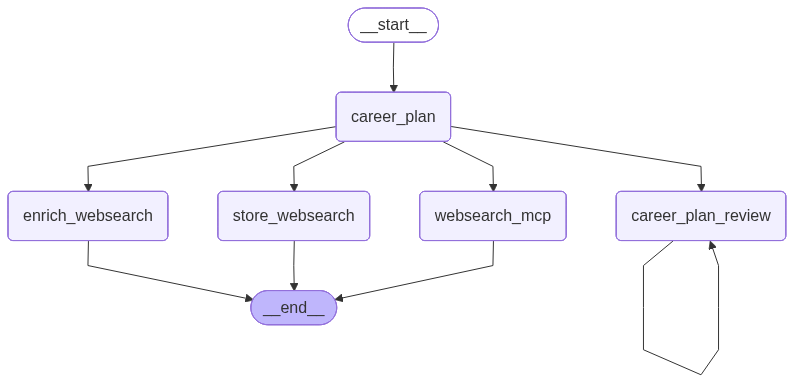

In [ ]:
from IPython.display import Image, display
    # Assuming 'graph' is your compiled LangGraph object
display(Image(plan_graph.get_graph().draw_mermaid_png(max_retries=5)))

In [1]:
from fastapi import FastAPI

app = FastAPI()


@app.get("/")
async def root():
    return {"message": "Hello World"}

In [1]:
import os
import json
import operator
from typing import TypedDict, Annotated, Optional

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.types import Command, interrupt

import os
from pymongo import MongoClient
import traceback

import asyncio
import time
import functools
import logging

from dotenv import load_dotenv

load_dotenv()  # <-- MUST be at the very top before any os.getenv

APIFY_TOKEN = os.getenv("APIFY_API_KEY")  #

# Set up basic logging
logging.basicConfig(level=logging.INFO)

# Circuit breaker state
circuit_open = False
failure_count = 0
failure_threshold = 3  # Open circuit after 3 consecutive failures
circuit_reset_time = 30  # seconds
last_failure_time = 0


def llm_call_with_retry_circuit(prompt: str, max_retries=3, retry_delay=2):
    """
    Wrapper for model.generate_content with:
    - Retry on transient errors
    - Circuit breaker to stop repeated failures
    - Token/cost logging
    """
    global circuit_open, failure_count, last_failure_time

    # Circuit breaker check
    if circuit_open:
        if time.time() - last_failure_time < circuit_reset_time:
            logging.warning("Circuit open. Skipping LLM call.")
            raise RuntimeError("Circuit open due to repeated failures")
        else:
            logging.info("Resetting circuit breaker.")
            circuit_open = False
            failure_count = 0

    for attempt in range(1, max_retries + 1):
        try:
            res = model.generate_content(prompt)

            # Logging token/cost info if available
            if hasattr(res, "usage"):
                tokens = res.usage.get("total_tokens", "N/A")
                cost = tokens * 0.00001  # Example: adjust based on model pricing
                logging.info(
                    f"LLM call successful | Tokens used: {tokens} | Est. cost: ${cost:.6f}"
                )

            # Reset failure count on success
            failure_count = 0
            return res

        except Exception as e:
            logging.warning(f"LLM call failed on attempt {attempt}: {e}")
            failure_count += 1
            last_failure_time = time.time()
            if failure_count >= failure_threshold:
                circuit_open = True
                logging.error(
                    f"Circuit opened after {failure_count} consecutive failures."
                )
            if attempt < max_retries:
                time.sleep(retry_delay)
            else:
                raise RuntimeError(f"LLM call failed after {max_retries} attempts: {e}")


# Try to use MongoDB persistence, fallback to memory if not available
try:
    from langgraph.checkpoint.mongodb import MongoDBSaver

    mongo_url = os.getenv("MONGODB_URI", "mongodb://localhost:27017")

    # --- Explicit connection check ---
    client = MongoClient(mongo_url, serverSelectionTimeoutMS=2000)
    client.admin.command("ping")  # will raise if not connected

    db_name = "career_bot"
    collection_name = "checkpoints"
    db = client["career_bot"]
    collection = db["checkpoints"]

    # --- Force creation of DB + collection by inserting a dummy if empty ---
    if collection.count_documents({}) == 0:
        collection.insert_one({"_init": True})
        print(f"Created DB '{db_name}' and collection '{collection_name}'")

    # --- LangGraph Saver ---
    memory = MongoDBSaver(
        client=client, db_name="career_bot", collection_name="checkpoints"
    )

    print("Using MongoDB persistence")

except Exception as e:
    from langgraph.checkpoint.memory import MemorySaver

    memory = MemorySaver()
    tb = traceback.format_exc()
    print(f"Falling back to in-memory persistence: {e}|trace={tb}")


import google.generativeai as genai
from scraper_utils import scrape_and_clean_profile

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
model = genai.GenerativeModel("models/gemini-1.5-flash")


def _log_transition(thread_id: str, node: str, action: str, note: str = ""):
    try:
        logging.info(f"[flow] thread={thread_id} node={node} action={action} {note}")
    except Exception:
        pass


class AgentState(TypedDict, total=False):
    messages: Annotated[list[BaseMessage], operator.add]
    profile_data: Annotated[dict, lambda _, x: x]
    current_job_description: Annotated[Optional[str], lambda _, x: x]
    linkedin_url: Annotated[Optional[str], lambda _, x: x]
    thread_id: Annotated[Optional[str], lambda _, x: x]  
    websearch_results: Annotated[list, lambda _, x: x]
    websearch_summary: Annotated[list, lambda _, x: x]
    # FIX 1: Add flag to track if profile was already scraped
    profile_scraped: Annotated[bool, lambda _, x: x]
    awaiting_input_for: Annotated[Optional[str], lambda _, x: x]
    user_plan: Annotated[Optional[str], lambda _, x: x]
    plan_history: Annotated[list[str], lambda _, x: x]
    last_user_prompt: Annotated[Optional[str], lambda _, x: x]


from apify_client import ApifyClient
import time

# FIX 3: Improved websearch with better error handling and link extraction
def websearch_mcp_node(state: AgentState) -> dict:
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "websearch_mcp", "start")
    messages = state.get("messages", [])
    messages.append(AIMessage("🔍 Fetching web data..."))

    # extract latest human query
    query = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            query = msg.content.strip()
            break

    if not query:
        messages.append(AIMessage("⚠ No query provided for web search."))
        state["messages"] = messages
        _log_transition(thread_id, "websearch_mcp", "done", "no-query")
        return state

    api_token = os.getenv("APIFY_API_KEY")
    if not api_token:
        messages.append(AIMessage("❌ Apify API token not configured."))
        state["messages"] = messages
        _log_transition(thread_id, "websearch_mcp", "done", "no-token")
        return state

    client = ApifyClient(api_token)
    actor_id = "WMg2EXLzJGPVQ5Vfq"   # âœ… stick with the tested actor

    input_data = {
        "query": query,
        "num": 1,
        "start": 1
    }

    max_retries = 3
    retry_delay = 2
    results = []

    for attempt in range(1, max_retries + 1):
        try:
            logging.info(f"Starting Apify web search for: {query}")
            run = client.actor(actor_id).call(run_input=input_data)

            dataset_items = client.dataset(run["defaultDatasetId"]).list_items().items
            print(dataset_items)
            logging.info(f"Retrieved {len(dataset_items)} items from Apify")

            for item in dataset_items:
                result = {
                    "title": item.get("title", ""),
                    "snippet": item.get("snippet", ""),
                    "link": item.get("link", ""),
                    "date": item.get("date")
                }
                results.append(result)

            print("printing search results:", results)


            if results:
                messages.append(
                    AIMessage(
                        f"ðŸ” WebSearch results fetched ({len(results)} results):\n"
                        + "\n".join([f"- {r['title']}: {r['link']}" for r in results[:3]])
                    )
                )
            else:
                messages.append(AIMessage("⚠ No search results found."))
            break

        except Exception as e:
            logging.error(f"Apify search attempt {attempt} failed: {e}")
            if attempt < max_retries:
                messages.append(AIMessage(f"⚠ Apify attempt {attempt} failed. Retrying..."))
                time.sleep(retry_delay)
            else:
                messages.append(AIMessage(f"❌ Apify WebSearch failed after {max_retries} attempts: {e}"))

    state["messages"] = messages
    state["websearch_results"] = results
    state["web_search"] = results
    _log_transition(thread_id, "websearch_mcp", "done", f"results={len(results)}")
    return state



def enrich_websearch_node(state):
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "enrich_websearch", "start")
    messages = state.get("messages", [])
    results = state.get("websearch_results", [])
    
    if not results:
        messages.append(AIMessage("⚠ No search results to enrich."))
        state["messages"] = messages
        _log_transition(thread_id, "enrich_websearch", "done", "no-results")
        return state

    summary = []
    for r in results:
        # Use snippet if available, otherwise try to fetch content
        content = r.get("snippet") or r.get("content") or r.get("description", "")
        
        if not content and r.get("link"):
            # Fallback to simple content fetch
            try:
                import requests
                response = requests.get(r["link"], timeout=10, headers={
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
                })
                content = response.text[:2000]  # Limit content
            except Exception as e:
                content = f"Could not fetch content: {e}"

        # Summarize content
        try:
            if content and len(content) > 50:
                summary_prompt = f"Summarize the key points for career planning from this content:\n\n{content[:1500]}"
                res = llm_call_with_retry_circuit(summary_prompt)
                summary_text = res.text
            else:
                summary_text = content or "No content available"
                
            summary.append({
                "title": r["title"], 
                "link": r["link"], 
                "summary": summary_text[:500]  # Limit summary length
            })
            
        except Exception as e:
            logging.error(f"Error enriching search result: {e}")
            summary.append({
                "title": r["title"], 
                "link": r["link"], 
                "summary": f"âŒ Could not summarize: {e}"
            })

    messages.append(AIMessage(f"✅ Search results enriched with AI summaries ({len(summary)} results)."))
    state["messages"] = messages
    state["websearch_summary"] = summary
    _log_transition(thread_id, "enrich_websearch", "done", f"summary={len(summary)}")
    return state


def store_websearch_node(state: AgentState) -> dict:
    """No-op for DB. Keep websearch_summary in state only; storage happens in plan/review nodes."""
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "store_websearch", "done")
    return state





# FIX 1: Improved LinkedIn scraper that only runs when needed
def linkedin_scraper_node(state: dict) -> dict:
    """
    Scrapes LinkedIn profile URL only if not already scraped in this session.
    """
    messages = state.get("messages", [])
    thread_id = state.get("thread_id", "default_thread")
    profile_scraped = state.get("profile_scraped", False)
    existing_profile = state.get("profile_data")

    # FIX 1: Skip scraping if profile already exists and was scraped
    _log_transition(thread_id, "linkedin_scraper", "start")
    if profile_scraped and existing_profile:
        logging.info("Profile already scraped in this session, skipping scraper")
        _log_transition(thread_id, "linkedin_scraper", "goto", "career_qa_router")
        return Command(goto=["career_qa_router"], update=state)

    linkedin_url = state.get("linkedin_url", "").strip()

    if not linkedin_url:
        messages.append(AIMessage("Please provide a LinkedIn profile URL to begin."))
        state["messages"] = messages
        _log_transition(thread_id, "linkedin_scraper", "interrupt", "awaiting URL")
        return interrupt("await_input")

    messages.append(AIMessage("Scraping your LinkedIn profile..."))

    try:
        scraped_profile = scrape_and_clean_profile(
            linkedin_url=linkedin_url, api_token=os.getenv("APIFY_API_KEY")
        )

        if not scraped_profile:
            messages.append(AIMessage("Failed to extract profile. Try again."))
            state["messages"] = messages
            _log_transition(thread_id, "linkedin_scraper", "interrupt", "scrape failed")
            return interrupt("await_input")

        messages.append(AIMessage("Profile successfully scraped!"))
        state["profile_data"] = scraped_profile
        state["profile_scraped"] = True  # FIX 1: Mark as scraped
        state["messages"] = messages
        state["thread_id"] = thread_id

    except Exception as e:
        messages.append(AIMessage(f"Error scraping LinkedIn profile: {e}"))
        state["messages"] = messages
        _log_transition(thread_id, "linkedin_scraper", "interrupt", "exception during scrape")
        return interrupt("await_input")

    _log_transition(thread_id, "linkedin_scraper", "goto", "career_qa_router")
    return Command(goto=["career_qa_router"], update=state)


def career_qa_router(state: AgentState) -> Command:
    thread_id = state.get("thread_id", "default_thread")
    profile = state.get("profile_data", {})
    jd = state.get("current_job_description", "")
    messages = state.get("messages", [])
    _log_transition(thread_id, "career_qa_router", "start")
    question = ""

    # Determine last speaker and latest human question
    last_is_human = False
    for msg in reversed(messages):
        if isinstance(msg, AIMessage):
            last_is_human = False
            break
        if isinstance(msg, HumanMessage):
            question = msg.content.strip()
            last_is_human = True
            break

    # If profile not scraped yet, route back to analyze_profile to handle scraping/tool call
    if not state.get("profile_scraped") or not state.get("profile_data"):
        _log_transition(thread_id, "career_qa_router", "goto", "analyze_profile")
        return Command(goto="analyze_profile", update=state)

    # If last message is not from human, wait for next input
    if not last_is_human or not question:
        state["messages"] = messages
        _log_transition(thread_id, "career_qa_router", "interrupt", "awaiting next question")
        return interrupt("await_input")

    if question.lower() in {"quit", "exit", "stop"}:
        messages.append(AIMessage("Okay, ending the conversation."))
        _log_transition(thread_id, "career_qa_router", "goto", "END")
        return Command(goto=END, update={"messages": messages})

    if "job description:" in question.lower():
        messages.append(AIMessage("Got your new job description."))
        state["messages"] = messages
        state["current_job_description"] = question
        _log_transition(thread_id, "career_qa_router", "interrupt", "job description captured")
        return interrupt("await_input")

    

    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )
    prompt = f"""
    {history}
You are an expert routing agent. Decide which module should handle the user's latest question. Understand what the user is asking exactly and use that understanding to make an informed routing decision.

Return one of:
- analyze_profile
- job_fit_agent
- enhance_profile
- general_qa
 - career_plan

DO NOT GUESS. Use the following rules:

---

ROUTE TO: analyze_profile
If the user wants a LinkedIn/resume/profile review, feedback, strengths, weaknesses, or audit. Use this if the user is seeking insights or improvements on their LinkedIn profile.

Examples:
- "Can you review my LinkedIn?"
- "What are my strengths and weaknesses?"
- "Audit my profile"
- Or any other question that implies analyzing the profile.
---

ROUTE TO: job_fit_agent:
If the user wants to assess their fit for a specific job or role. Only route here if a job description was recently provided. And if the user is referencing it in their question.

If the user says anything like:
- "Does my profile match this JD?"
- "Am I eligible for this job?"
- "Score me against this role"
- Or any other question that implies matching the profile to a job description.



---

ROUTE TO: enhance_profile
If the user is asking you to audit or improve their profile or a part of their profile. Understand their specific needs and context properly.

If the user asks for:
- Rewriting/resume improvement
- Profile optimization
- "Improve my About section"
- "Rewrite my Experience bullets"
- Or any other question that implies enhancing the profile.


---

ROUTE TO: general_qa
If the user has any other general career questions. If none of the above 3 routes apply, use this. Answer it precisely and informatively.

Examples:
- "What kind of roles should I target?"
- "How do I switch fields?"
- "What are good certifications for data science?"
- "How do I get into startups?"
- Or any other question that doesn't fit the above categories.

---

ROUTE TO: career_plan
If the user asks to create/build/design a career plan/roadmap, revise/refine a plan, or mentions planning goals/timelines (e.g., "build me a 6-month plan", "revise my career plan", "roadmap to become X").

Examples:
- "Build me a career plan"
- "Create a roadmap for AI roles"
- "Revise the plan to focus on ML"

USER QUESTION:
{question}

Just respond with ONE of:
analyze_profile, job_fit_agent, enhance_profile, general_qa, career_plan
"""

    try:
        result = llm_call_with_retry_circuit(prompt)
        decision = result.text.strip().lower()
        # Normalize common phrasing to decisions
        valid_nodes = {
            "analyze_profile",
            "job_fit_agent",
            "enhance_profile",
            "general_qa",
            "career_plan",
        }
        if decision in valid_nodes:
            # Handle JD missing case for job fit intent
            if decision == "job_fit_agent" and not jd:
                state["awaiting_input_for"] = "job_description"
                messages.append(AIMessage("Please paste the job description you want me to check against."))
                state["messages"] = messages
                _log_transition(thread_id, "career_qa_router", "goto", "user_interaction")
                return Command(goto="user_interaction", update=state)
            # Good, we trust it
            mapped = (
                "general_qa_node" if decision == "general_qa" else (
                    "career_plan_combined" if decision == "career_plan" else decision
                )
            )
            return Command(goto=mapped,
                        update=state)
        else:
            # Fail gracefully
            messages.append(AIMessage("⚠️ Sorry, I couldn't decide where to route this."))
            state["messages"] = messages
            _log_transition(thread_id, "career_qa_router", "interrupt", f"invalid decision: {decision}")
            return interrupt()
    except Exception as e:
        messages.append(AIMessage(f"⚠️  Routing error: {e}"))
        state["messages"] = messages
        _log_transition(thread_id, "career_qa_router", "interrupt", "routing exception")
        return interrupt()


def analyze_profile_node(state: AgentState) -> dict:
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "analyze_profile", "start")
    profile = state.get("profile_data")
    messages = state.get("messages", [])

    # If no profile scraped yet, either ask for URL or call scraper tool
    if not state.get("profile_scraped") or not profile:
        linkedin_url = (state.get("linkedin_url") or "").strip()
        if not linkedin_url:
            state["awaiting_input_for"] = "linkedin_url"
            _log_transition(thread_id, "analyze_profile", "interrupt", "awaiting linkedin url")
            return interrupt("Please enter your LinkedIn profile URL to begin.")
        try:
            messages.append(AIMessage("Scraping your LinkedIn profile..."))
            scraped_profile = scrape_and_clean_profile(
                linkedin_url=linkedin_url, api_token=os.getenv("APIFY_API_KEY")
            )
            if not scraped_profile:
                messages.append(AIMessage("Failed to extract profile. Try again."))
                state["messages"] = messages
                _log_transition(thread_id, "analyze_profile", "interrupt", "scrape failed")
                return interrupt("Could not scrape profile. Please check the URL or try again.")
            state["profile_data"] = scraped_profile
            state["profile_scraped"] = True
            messages.append(AIMessage("Profile successfully scraped!"))
        except Exception as e:
            messages.append(AIMessage(f"Error scraping LinkedIn profile: {e}"))
            state["messages"] = messages
            return interrupt("Scraping failed. Provide a valid URL or try later.")

    profile = state.get("profile_data")
    state["messages"] = messages

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}
        You are a highly experienced career coach and tech recruiter who has reviewed over 10,000 LinkedIn profiles.

        Your job is to critically evaluate the following LinkedIn profile and return a brutally honest, section-wise analysis.

        Use the following criteria for evaluation:
        1. Clarity and professionalism of writing
        2. Technical and strategic relevance of content
        3. Recruiter impression: Would you shortlist this profile?

        ---

        {profile_text}

        ---

        ### Return output in the following structure:

        # LinkedIn Profile Audit

        ## Strengths  
        List 3â€“5 strengths that stand out across the profile.

        ## Weaknesses  
        List 3â€“5 major weaknesses holding the profile back.
 ## Section-by-Section Evaluation  
        For each section (About, Experience, Projects, Education, Skills, etc.), write:

        - Give a quality score: âœ… Strong / âš  Needs improvement / âŒ Missing  
        - Provide 2â€“3 suggestions to improve the section (content, phrasing, structure)  
        - Use clean formatting: bold headings, bullet points, and avoid unnecessary repetition.

        Constraints:
        - Max 4 bullet points per section  
        - Each bullet: <30 words  
        - Total section feedback: <100 words

        ## Top 3 Improvements You Must Make Now  
        Each point must be:
        - Brutally specific  
        - Directly actionable  
        - One line only
        
        Precautions:
        - Do not hallucinate and stay within context.
        - If the user asks for/about a specific section (e.g., "improve my projects"), focus only on that section.
        
        Begin now.
        """.strip()
        
        
    res = None


    try:
        res = llm_call_with_retry_circuit(prompt)
        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"âŒ Error: {e}"))
        state["messages"] = messages
        
    if res:
        try:
            user_query = extract_latest_user_query(messages)
            thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=res.text,
                user_id=get_user_id_from_profile(profile)
            )
        except Exception as e:
            logging.error(f"Failed to store QA graph output: {e}")

    _log_transition(thread_id, "analyze_profile", "goto", "career_qa_router")
    return Command(goto="career_qa_router", update=state)


def job_fit_agent_node(state: AgentState) -> dict:
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "job_fit_agent", "start")
    profile = state.get("profile_data")
    jd = state.get("current_job_description", "")
    messages = state["messages"]
    if not profile or not jd:
        messages.append(AIMessage("âš  Missing profile or job description."))
        state["messages"] = messages
        return interrupt()

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}
        You are a highly experienced AI Job Fit Evaluator trained on thousands of hiring decisions across several job roles.
        Your job is to evaluate how well the candidate's profile matches the given job description.       
        ---

        JOB DESCRIPTION:
        {jd}

        CANDIDATE PROFILE:
        {profile_text}

        ---

        TASKS:
        1. Evaluate the fitness of the candidate for this job role using industry-standard evaluation practices (skills, experience, keywords, impact, achievements, and alignment).
        2. Return a Job Match Score out of 100, and explain how you arrived at it with specific reasoning.
        3. List 3â€“5 strengths from the candidate's profile that match the job expectations.
        4. Suggest 3â€“5 concrete improvements â€“ these could include skill gaps, experience tweaks, weak areas in phrasing, or missing proof of impact.
  5. Only evaluate against the given job role. Do not assume adjacent job titles are valid matches.
        6. If the candidate seems overqualified or underqualified, clearly state it and explain how that affects the match.

        ---

        OUTPUT FORMAT:
        # ðŸŽ¯ Job Fit Evaluation

        ## âœ… Job Match Score: XX/100
        - One-line explanation of the score.
        - 2â€“3 bullets with specific justification.

        ## ðŸŸ© Strengths
        - Point 1 (aligned with JD)
        - Point 2
        - Point 3  
        (Each point â‰¤ 40 words)

 ## ðŸŸ¥ Weaknesses
        - specify the top 3-4 points as to why this profile doesn't match the job or will get rejected even if applied and this analysis must be honest and brutal
        (Each point â‰¤ 40 words)

        ## ðŸ›  Improvements to Increase Match Score
        - Point 1 (what to improve and how)
        - Point 2
        - Point 3  
        (Each point â‰¤ 25 words)

        ## ðŸ“Œ Verdict
        Clearly say if the candidate is a strong match, weak match, or needs improvement to apply. Give a one-liner summary.
        
        Precautions:
        - Do not hallucinate and stay within context.
        - If the user asks for/about a specific section (e.g., "improve my projects"), focus only on that section.
        
        Begin now.
""".strip()


    res = None


    try:
        res = llm_call_with_retry_circuit(prompt)

        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"âŒ Error: {e}"))
        state["messages"] = messages
    
    if res:
        try:
            user_query = extract_latest_user_query(messages)
            thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=res.text,
                user_id=get_user_id_from_profile(profile)
            )
        except Exception as e:
            logging.error(f"Failed to store QA graph output: {e}")

    _log_transition(thread_id, "job_fit_agent", "goto", "career_qa_router")
    return Command(goto="career_qa_router", update=state)


def enhance_profile_node(state: AgentState) -> dict:
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "enhance_profile", "start")
    profile = state.get("profile_data")
    jd = state.get("current_job_description", "")
    messages = state["messages"]
    if not profile:
        messages.append(AIMessage("âš  No profile found to enhance."))
        state["messages"] = messages
        return interrupt()

    profile_text = "\n".join(f"{k}: {v}" for k, v in profile.items())
    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
{history}
        You are a highly experienced LinkedIn Profile Optimization AI, trained on millions of real-world hiring patterns across top companies like Google, Amazon, Meta, and startups. Your task is to analyze and rewrite the user's LinkedIn profile to improve clarity, strength, and impact.

        CONTEXT:
        - The user may or may not have shared a job description.
        - They might be asking to improve a specific section only (e.g., "improve my projects to match this JD").
        - You should infer goals from the user's question and adjust accordingly.
        - If any question is related to the job description/JD then consider that and then provide an output

        CURRENT PROFILE:
        {profile_text}  

        JOB DESCRIPTION/JD:
        {jd}
  TASKS:
        1. Identify weak sections and rewrite them to be stronger, more professional, and better aligned with either:
            - the job description (if provided), or
            - general hiring best practices (if no JD is given).
        2. Preserve all factual details. Do NOT add imaginary experiences.
        3. Use bullet points only where appropriate (e.g., Experience, Projects).
        4. Each bullet must be â‰¤ 25 words, and **max 4 bullets per section.
        5. For the "About" section, limit to 2â€“3 tight paragraphs, total **â‰¤ 250 words.
        6. Add impactful verbs, metrics, and proof of value wherever possible.
        7. If the user requested only a section enhancement (e.g., just projects), modify only that section.
        8. If the user asks for a specific section (e.g., "improve my projects"), focus only on that section, DO NOT TALK ABOUT OTHER SECTIONS.

        FORMAT:
        Return the improved sections in clean Markdown format.
        - Use bold section titles.
        - Show only modified sections â€“ skip untouched ones to save tokens.
        - Make sure the rewritten content feels real, focused, and hiring-ready.

Precautions:
        - Do not hallucinate and stay within context.
        - If the user asks for/about a specific section (e.g., "improve my projects"), focus only on that section.

        Begin now.
""".strip()


    res = None


    try:
        res = llm_call_with_retry_circuit(prompt)

        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"âŒ Error: {e}"))
        state["messages"] = messages
        
        
    if res:
        try:
            user_query = extract_latest_user_query(messages)
            thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=res.text,
                user_id=get_user_id_from_profile(profile)
            )
        except Exception as e:
            logging.error(f"Failed to store QA graph output: {e}")

    _log_transition(thread_id, "enhance_profile", "goto", "career_qa_router")
    return Command(goto="career_qa_router", update=state)


def general_qa_node(state: AgentState) -> dict:
    thread_id = state.get("thread_id", "default_thread")
    _log_transition(thread_id, "general_qa_node", "start")
    profile = state.get("profile_data")
    jd = state.get("current_job_description", "")
    messages = state["messages"]
    question = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            question = msg.content.strip()
            break

    history = "\n".join(
        f"Human: {m.content}" if isinstance(m, HumanMessage) else f"AI: {m.content}"
        for m in messages[-5:]
    )

    prompt = f"""
You are a helpful, concise, and highly experienced career guidance assistant.

Your task is to answer general career-related questions from users

The user may ask about:
- Career advice
- Interview preparation
- Certifications
- Job search strategy
- Skill-building
- Remote work
- Career switches
- Industry trends
- Anything else loosely related to career growth

---

USER CONTEXT (optional):
{history}

PROFILE DATA:
{state.get("profile_data", "N/A")}

JOB DESCRIPTION (if any):
{state.get("current_job_description", "N/A")}

QUESTION:
{question}

---

### Answer Guidelines:

- Answer clearly and concisely.
- Prioritize useful, actionable advice.
- If the question is vague or broad, ask a clarifying follow-up.
- Keep the tone supportive but professional.
- Do not suggest uploading a resume or LinkedIn again.
- If you detect the user is stressed, confused, or unsure, acknowledge that supportively.

---

### Output Format:

Respond in clean text. Use bullet points or short paragraphs where needed.

Start now.
""".strip()


    res = None


    try:
        res = llm_call_with_retry_circuit(prompt)

        messages.append(AIMessage(res.text))
        state["messages"] = messages
    except Exception as e:
        messages.append(AIMessage(f"âŒ Error: {e}"))
        state["messages"] = messages

    
    if res:
        try:
            user_query = extract_latest_user_query(messages)
            thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=res.text,
                user_id=get_user_id_from_profile(profile)
            )
        except Exception as e:
            logging.error(f"Failed to store QA graph output: {e}")

    _log_transition(thread_id, "general_qa_node", "goto", "career_qa_router")
    return Command(goto="career_qa_router", update=state)


def user_interaction_node(state: AgentState) -> dict:
    """Handles human-in-the-loop input requests like JD or LinkedIn URL."""
    thread_id = state.get("thread_id", "default_thread")
    awaiting = state.get("awaiting_input_for")
    messages = state.get("messages", [])

    # Extract latest human message
    latest_human = None
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            latest_human = msg.content.strip()
            break

    # If we're waiting for JD
    if awaiting == "job_description":
        if latest_human:
            state["current_job_description"] = latest_human
            state["awaiting_input_for"] = None
            _log_transition(thread_id, "user_interaction", "goto", "career_qa_router")
            return Command(goto="career_qa_router", update=state)
        _log_transition(thread_id, "user_interaction", "interrupt", "await_jd")
        return interrupt("Please paste the job description you want me to check against.")

    # If we're waiting for LinkedIn URL
    if awaiting == "linkedin_url":
        if latest_human and latest_human.startswith("http"):
            state["linkedin_url"] = latest_human
            state["awaiting_input_for"] = None
            _log_transition(thread_id, "user_interaction", "goto", "analyze_profile")
            return Command(goto="analyze_profile", update=state)
        _log_transition(thread_id, "user_interaction", "interrupt", "await_linkedin")
        return interrupt("Please provide a valid LinkedIn profile URL.")

    # Default: nothing awaited; pause for next user input
    _log_transition(thread_id, "user_interaction", "interrupt", "idle")
    return interrupt("Waiting for your input. Ask a question or provide details.")


# Import remaining modules as in original...
# (ThreadBasedProceduralMemory class and other imports remain the same)

# ThreadBasedProceduralMemory class - keep as is from original
class ThreadBasedProceduralMemory:
    """Enhanced procedural learning with thread-based storage in MongoDB"""

    def __init__(self, mongo_url: str = None, db_name: str = "career_bot"):
        self.mongo_url = mongo_url or os.getenv("MONGODB_URI", "mongodb://localhost:27017")
        self.db_name = db_name
        self.collection_name = "procedural_threads"
        self._client = MongoClient(self.mongo_url) 
        self._collection = None
        self._initialize_connection()
    
    def _initialize_connection(self):
        """Initialize MongoDB connection"""
        try:
            self._client = MongoClient(self.mongo_url, serverSelectionTimeoutMS=5000)
            self._client.admin.command("ping")
            db = self._client[self.db_name]
            self._collection = db[self.collection_name]
            
            # Create indexes for efficient querying
            self._collection.create_index("thread_id")
            self._collection.create_index("user_id") 
            self._collection.create_index([("conversations.user_query", "text")])
            
            logging.info("ThreadBasedProceduralMemory initialized successfully")
            
        except Exception as e:
            logging.error(f"Failed to initialize MongoDB: {e}")
            self._client = None
            self._collection = None
    
    def _is_connected(self) -> bool:
        """Check MongoDB connection - FIXED"""
        if self._client is None or self._collection is None:
            return False
        try:
            self._client.admin.command("ping")
            return True
        except:
            return False
    
    def store_thread_data(self, thread_id: str, profile_data: dict, 
                         user_query: str, ai_response: str, user_id: str = None,
                         web_search: Optional[list] = None) -> bool:
        """Store or update thread data with profile and conversation - FIXED"""
        if not self._is_connected():
            logging.error("MongoDB not connected")
            return False
        
        try:
            from datetime import datetime
            # Prepare conversation entry
            # Two-bucket model:
            # 1) web_links aggregator bucket
            # 2) query_response bucket
            web_bucket = {
                "timestamp": datetime.utcnow().isoformat(),
                "bucket": "web_links",
                "web_search": web_search or []
            } if web_search else None

            query_bucket = {
                "timestamp": datetime.utcnow().isoformat(),
                "bucket": "query_response",
                "user_query": user_query[:1000],
                "ai_response": ai_response[:3000],
                "query_type": self._classify_query(user_query)
            }
            
            # Check if thread exists - FIXED: Use count_documents instead
            existing_count = self._collection.count_documents({"thread_id": thread_id})
            
            if existing_count > 0:
    # always update profile + last_updated
                self._collection.update_one(
                    {"thread_id": thread_id},
                    {"$set": {"last_updated": datetime.utcnow().isoformat(),
                            "profile_data": profile_data}}
                )

                # if we have web_search results, update the web_links bucket
                if web_search:
                    valid_web = [w for w in web_search if not w.get("error")]
                    if valid_web:
                        self._collection.update_one(
                            {"thread_id": thread_id},
                            {"$push": {"conversations.$[web].web_search": {"$each": valid_web}}},
                            array_filters=[{"web.bucket": "web_links"}]
                        )

                # --- this part must run for ALL queries, not only with web_search ---
                bucket_name = (
                    "career_planning"
                    if self._classify_query(user_query) == "career_planning"
                    else "qa_graph"
                )

                # ensure bucket exists
                self._collection.update_one(
                    {"thread_id": thread_id, "conversations.bucket": {"$ne": bucket_name}},
                    {"$push": {"conversations": {"bucket": bucket_name, "entries": []}}}
                )

                # append new entry
                self._collection.update_one(
                    {"thread_id": thread_id},
                    {"$push": {f"conversations.$[bucket].entries": {
                        "user_query": user_query[:1000],
                        "ai_response": ai_response[:3000],
                        "query_type": self._classify_query(user_query),
                        "timestamp": datetime.utcnow().isoformat()
                    }}},
                    array_filters=[{"bucket.bucket": bucket_name}],
                )





                
            else:
                # Create new thread
                # Decide bucket purely based on which graph is running (passed from state)
                graph_type = profile_data.get("_graph_type", "qa_graph")
                bucket_name = "career_planning" if graph_type == "plan_graph" else "qa_graph"


                thread_data = {
                    "thread_id": thread_id,
                    "user_id": user_id or "unknown",
                    "created_at": datetime.utcnow().isoformat(),
                    "last_updated": datetime.utcnow().isoformat(),
                    "profile_data": profile_data,
                    "conversations": [
                        {"bucket": "web_links", "web_search": web_search or []},
                        {"bucket": "career_planning", "entries": []},
                        {"bucket": "qa_graph", "entries": []},
                    ],
                }

                # append first entry into the correct bucket
                entry = {
                    "user_query": user_query[:1000],
                    "ai_response": ai_response[:3000],
                    "query_type": self._classify_query(user_query),
                    "timestamp": datetime.utcnow().isoformat()
                }

                for conv in thread_data["conversations"]:
                    if conv["bucket"] == bucket_name:
                        conv.setdefault("entries", []).append(entry)

                self._collection.insert_one(thread_data)

            
            logging.info(f"Stored thread data for {thread_id}")
            return True
            
        except Exception as e:
            logging.error(f"Failed to store thread data: {e}")
            return False
    
    def get_similar_threads(self, query: str, current_thread_id: str = None, 
                          user_id: str = None, limit: int = 3) -> list[dict]:
        """Get similar threads based on query similarity"""
        if not self._is_connected():
            return []
        
        try:
            from typing import Dict, List
            
            # Build query
            mongo_query = {}
            if user_id:
                mongo_query["user_id"] = user_id
            
            # Exclude current thread
            if current_thread_id:
                mongo_query["thread_id"] = {"$ne": current_thread_id}
            
            # Simple find without text search for now
            cursor = self._collection.find(mongo_query).limit(limit * 2)  # Get more to filter
            
            results = []
            query_words = set(query.lower().split())
            
            for thread in cursor:
                score = 0
                
                # Calculate similarity score based on conversation content
                for conv in thread.get("conversations", [])[-5:]:  # Last 5 conversations
                    conv_words = set(conv.get("user_query", "").lower().split())
                    overlap = len(query_words.intersection(conv_words))
                    if overlap > 0:
                        score += overlap * 2
                
                if score > 0:
                    thread["similarity_score"] = score
                    results.append(thread)
            
            # Sort by similarity score and limit
            results.sort(key=lambda x: x.get("similarity_score", 0), reverse=True)
            results = results[:limit]
            
            logging.info(f"Found {len(results)} similar threads for query: {query[:50]}")
            return results
            
        except Exception as e:
            logging.error(f"Failed to get similar threads: {e}")
            return []
    
    def get_thread_data(self, thread_id: str) -> Optional[dict]:
        """Get complete thread data"""
        if not self._is_connected():
            return None
        
        try:
            from typing import Optional, Dict
            thread_data = self._collection.find_one({"thread_id": thread_id})
            if thread_data and "_id" in thread_data:
                thread_data["_id"] = str(thread_data["_id"])
            return thread_data
        except Exception as e:
            logging.error(f"Failed to get thread data: {e}")
            return None
    
    def _classify_query(self, query: str) -> str:
        """Classify the type of query for better matching"""
        query_lower = query.lower()
        
        if any(word in query_lower for word in ["career plan", "roadmap", "planning"]):
            return "career_planning"
        elif any(word in query_lower for word in ["switch", "transition", "change"]):
            return "career_transition"
        elif any(word in query_lower for word in ["skill", "learn", "course"]):
            return "skill_development"
        elif any(word in query_lower for word in ["resume", "profile", "linkedin"]):
            return "profile_optimization"
        else:
            return "general_career"
    
    def build_procedural_context(self, similar_threads: list[dict], max_context_length: int = 2000) -> str:
        """Build context from similar threads for prompt enhancement"""
        if not similar_threads:
            return ""
        
        context = "\n\nBased on similar career planning sessions:\n"
        
        for i, thread in enumerate(similar_threads[:2], 1):
            # Get profile context
            profile = thread.get("profile_data", {})
            profile_summary = f"Profile: {profile.get('headline', 'N/A')[:100]}"
            
            # Get successful conversations
            conversations = thread.get("conversations", [])
            if conversations:
                latest_conv = conversations[-1]
                query_snippet = latest_conv.get("user_query", "")[:150]
                response_snippet = latest_conv.get("ai_response", "")[:500]
                
                context += f"\nExample {i}:\n"
                context += f"  {profile_summary}\n"
                context += f"  Query: {query_snippet}...\n"
                context += f"  Approach: {response_snippet}...\n"
        
        # Truncate if too long
        if len(context) > max_context_length:
            context = context[:max_context_length] + "..."
        
        return context
    
    def get_user_stats(self, user_id: str) -> dict:
        """Get statistics about user's procedural memories"""
        if not self._is_connected():
            return {"error": "MongoDB not connected"}
        
        try:
            # Get all threads for this user
            user_threads = list(self._collection.find({"user_id": user_id}))
            
            total_threads = len(user_threads)
            total_conversations = 0
            query_types = {}
            latest_activity = None
            
            for thread in user_threads:
                conversations = thread.get("conversations", [])
                total_conversations += len(conversations)
                
                # Track query types
                for conv in conversations:
                    query_type = conv.get("query_type", "unknown")
                    query_types[query_type] = query_types.get(query_type, 0) + 1
                    
                    # Track latest activity
                    if not latest_activity or conv.get("timestamp", "") > latest_activity:
                        latest_activity = conv.get("timestamp")
            
            return {
                "user_id": user_id,
                "total_threads": total_threads,
                "total_conversations": total_conversations,
                "query_types": query_types,
                "latest_activity": latest_activity,
                "most_common_query_type": max(query_types.items(), key=lambda x: x[1])[0] if query_types else "none"
            }
            
        except Exception as e:
            logging.error(f"Failed to get user stats: {e}")
            return {"error": str(e)}

    def debug_thread(self, thread_id: str):
        """Debug helper for thread data"""
        thread_data = self.get_thread_data(thread_id)
        if thread_data:
            print(f"\n=== THREAD DEBUG: {thread_id} ===")
            print(f"User ID: {thread_data.get('user_id')}")
            print(f"Created: {thread_data.get('created_at')}")
            print(f"Conversations: {len(thread_data.get('conversations', []))}")
            print(f"Profile headline: {thread_data.get('profile_data', {}).get('headline', 'N/A')}")

            for i, conv in enumerate(thread_data.get('conversations', [])[-3:], 1):
                print(f"\nConversation {i}:")
                print(f"  Query: {conv.get('user_query', '')[:100]}...")
                print(f"  Type: {conv.get('query_type')}")
                print(f"  Response length: {len(conv.get('ai_response', ''))}")
        else:
            print(f"No data found for thread: {thread_id}")


# Initialize the enhanced procedural memory
thread_procedural_memory = ThreadBasedProceduralMemory()


# MCP client setup (keep same as original)
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
import sys

CAREER_PLAN_SERVER = os.path.abspath(
    "E:\\LinkedIn_AI_Career_Bot - Copy\\linkedin\\career_plan_mcp.py"
)

async def call_career_plan_mcp(profile_data, messages, system_prompt):
    """Async call to the career-plan MCP tool."""
    server_params = StdioServerParameters(
        command=sys.executable,
        args=[CAREER_PLAN_SERVER],
    )

    async with stdio_client(server_params) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            result = await session.call_tool(
                "generate_career_plan",
                arguments={
                    "profile_data": profile_data,
                    "messages": [
                        {
                            "role": "system",
                            "content": system_prompt,
                        }
                    ] + [
                        {
                            "role": (
                                "user" if isinstance(m, HumanMessage) else "assistant"
                            ),
                            "content": m.content,
                        }
                        for m in messages
                    ],
                },
            )
            return result.content[0].text


def get_user_id_from_profile(profile: dict) -> str:
    """Extract user ID from profile"""
    return profile.get("user_id", 
           profile.get("email", 
           profile.get("linkedin_url", 
           f"user_{hash(str(profile))}")))


def extract_latest_user_query(messages: list[BaseMessage]) -> str:
    """Extract the latest user query from messages"""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            return msg.content.strip()
    return ""

# def websearch_decider_node(state: AgentState) -> Command:
#     """Deprecated: we always run websearch before planning now."""
#     return Command(goto="websearch_mcp", update=state)



def _run_web_search_tools(state: AgentState) -> AgentState:
    """Utility to run web search + enrichment and update state."""
    try:
        updated = websearch_mcp_node(state)
        updated = enrich_websearch_node(updated)
        updated = store_websearch_node(updated)
        return updated
    except Exception:
        return state


def career_plan_combined_node(state: AgentState) -> dict:
    """Combined node: generate first plan, then handle iterative reviews in-place."""
    profile = state.get("profile_data", {})
    messages = state.get("messages", [])
    thread_id = state.get("thread_id", "default_thread")
    websearch_summary = state.get("websearch_summary", [])
    existing_plan = state.get("user_plan")
    
    if not messages:
        messages.append(AIMessage("Please provide a brief or question for your career plan."))
        state["messages"] = messages
        return interrupt("Please provide a brief or question for your career plan.")
    
    # Extract user query
    user_query = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            user_query = msg.content.strip()
            break
    
    if not user_query:
        messages.append(AIMessage("Please provide a specific question or request for your career plan."))
        state["messages"] = messages
        return interrupt("Please provide a specific question or request for your career plan.")
    
    user_id = get_user_id_from_profile(profile)
    logging.info(f"Processing career plan request for thread: {thread_id}")
    
    # Build enhanced prompt with conversation history context
    conversation_history = "\n".join([
        f"{'User' if isinstance(msg, HumanMessage) else 'Assistant'}: {msg.content[:200]}..."
        for msg in messages[-6:]  # Include more history for context
    ])
    
    # Base prompt with conversation context preservation
    base_prompt = f"""
You are an expert AI career coach with 10+ years of experience helping professionals advance their careers.

IMPORTANT: Pay careful attention about their specific goals, timeline, and field of interest.

CONVERSATION HISTORY:
{conversation_history}

CURRENT USER REQUEST: {user_query}

Key Instructions:
1. If they mentioned a specific role (like "finance analyst"), ALWAYS keep that in focus
2. If they mentioned a timeline (like "6 months" or "1 year"), respect that in your response
3. When they ask for modifications (like "make it 1 year instead"), apply the change to their ORIGINAL request, don't lose context
4. Be specific, actionable, and personalized to their profile and stated goals
5. Include concrete steps with timelines where appropriate
"""

    # Try to get similar threads for procedural learning
    try:
        similar_threads = thread_procedural_memory.get_similar_threads(
            query=user_query,
            current_thread_id=thread_id,
            user_id=user_id,
            limit=3
        )
        
        if similar_threads:
            procedural_context = thread_procedural_memory.build_procedural_context(similar_threads)
            enhanced_prompt = base_prompt + procedural_context + "\n\nNow generate a career plan for the current user, incorporating insights from these successful approaches while customizing for their specific profile and request."
            logging.info(f"Enhanced prompt with {len(similar_threads)} similar threads")
        else:
            enhanced_prompt = base_prompt
            logging.info("No similar threads found, using base prompt")
    except Exception as e:
        logging.error(f"Failed to retrieve similar threads: {e}")
        enhanced_prompt = base_prompt
    
    # Add web search results to prompt if available
    if websearch_summary:
        web_context = "\n\nWEB RESEARCH RESULTS (use these for current courses, certifications, and resources):\n"
        for i, result in enumerate(websearch_summary[:3], 1):
            web_context += f"{i}. {result.get('title', 'Unknown')}\n"
            web_context += f"   Summary: {result.get('summary', '')[:200]}...\n"
            web_context += f"   Link: {result.get('link', '')}\n\n"
        
        enhanced_prompt += web_context
        enhanced_prompt += "\n\nIMPORTANT: Include specific courses, certifications, and learning resources from the web research in your career plan."
        logging.info(f"Added web research context from {len(websearch_summary)} results")
    
    # Decide mode: first-time generation vs review
    is_review = existing_plan is not None

    if not is_review:
        # First-time generation → optionally run web search, then MCP
        state = _run_web_search_tools(state)
        try:
            mcp_raw = asyncio.run(call_career_plan_mcp(profile, messages, enhanced_prompt))
        except Exception as e:
            mcp_raw = f"Error generating career plan: {e} {traceback.format_exc()}"
            logging.error(f"Career plan generation failed: {e}")

        plan_output = mcp_raw
        try:
            import json as _json
            parsed = _json.loads(mcp_raw)
            if isinstance(parsed, dict):
                plan_output = parsed.get("plan_output", mcp_raw)
                extracted_web = parsed.get("websearch_summary")
                if isinstance(extracted_web, list):
                    state["websearch_summary"] = extracted_web
        except Exception:
            pass

        state["user_plan"] = plan_output
        state.setdefault("plan_history", [])
        state["plan_history"].append(plan_output)
        state["last_user_prompt"] = user_query

        try:
            web_results = state.get("websearch_summary") or state.get("websearch_results") or []
            thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=plan_output,
                user_id=user_id,
                web_search=web_results,
            )
        except Exception as e:
            logging.error(f"Failed to store initial plan: {e}")

        messages.append(AIMessage(plan_output))
        messages.append(AIMessage("Here's your plan draft. What would you like to adjust or refine?"))
        state["messages"] = messages
        return interrupt("Here's your plan draft. What would you like to adjust or refine?")
    else:
        # Review mode: use previous plan + current feedback + profile + optional fresh web search
        last_ai_plan = existing_plan
        state = _run_web_search_tools(state)

        websearch_summary = state.get("websearch_summary", [])
        web_context = ""
        if websearch_summary:
            web_context = "\n\nWEB RESEARCH:\n" + "\n".join(
                f"- {r.get('title','')}: {r.get('link','')}" for r in websearch_summary[:5]
            )

        prompt = f"""
You are refining an existing career plan based on human feedback. Pay attention to the changes and they must be incorporated into the plan.

Existing plan:
{last_ai_plan}

New feedback from user:
{user_query}
{web_context}

Rewrite ONLY the plan, integrating the feedback. Keep it structured, specific, and actionable. Preserve useful content; ONLY modify where needed.
"""
        try:
            res = llm_call_with_retry_circuit(prompt)
            revised = res.text
        except Exception as e:
            revised = f"❌ Error refining plan: {e}"

        state["user_plan"] = revised
        state.setdefault("plan_history", [])
        state["plan_history"].append(revised)
        state["last_user_prompt"] = user_query

        try:
            web_results = state.get("websearch_summary") or state.get("websearch_results") or []
            thread_procedural_memory.store_thread_data(
                thread_id=thread_id,
                profile_data=profile,
                user_query=user_query,
                ai_response=revised,
                user_id=user_id,
                web_search=web_results,
            )
        except Exception as e:
            logging.error(f"Failed to store revised plan: {e}")

        messages.append(AIMessage(revised))
        messages.append(AIMessage("Here's the revised version. Want to refine further?"))
        state["messages"] = messages
        return interrupt("Here's the revised version. Want to refine further?")
    


def career_plan_review_node(state: AgentState) -> dict:
    """Deprecated: functionality moved into career_plan_combined_node."""
    return Command(goto="career_plan_combined", update=state)




def build_qa_graph():
    """Segment 1: Analyze Profile (scrape if needed) → Router → task nodes; HIL via user_interaction."""
    builder = StateGraph(AgentState)

    # Nodes
    builder.add_node("linkedin_scraper", linkedin_scraper_node)
    builder.add_node("career_qa_router", career_qa_router)
    builder.add_node("analyze_profile", analyze_profile_node)
    builder.add_node("job_fit_agent", job_fit_agent_node)
    builder.add_node("enhance_profile", enhance_profile_node)
    builder.add_node("general_qa_node", general_qa_node)
    builder.add_node("user_interaction", user_interaction_node)

    # Entry at analyze_profile as per spec
    builder.set_entry_point("analyze_profile")

    # Scraper → router
    builder.add_edge("linkedin_scraper", "career_qa_router")

    # Router → nodes are dynamic via Command.go_to (no static fan-out edges)

    # Task nodes loop back to router; router will interrupt to await next question
    for task in ["analyze_profile", "job_fit_agent", "enhance_profile", "general_qa_node"]:
        builder.add_edge(task, "career_qa_router")

    # User interaction loops back to router/analyze as needed dynamically
    builder.add_edge("user_interaction", "career_qa_router")

    return builder.compile(checkpointer=memory)


def build_plan_graph():
    """Single-node combined planner with HIL review cycles via interrupts."""
    builder = StateGraph(AgentState)

    # Nodes
    builder.add_node("career_plan_combined", career_plan_combined_node)

    # Entry point = combined node
    builder.set_entry_point("career_plan_combined")

    # Self-loop to allow iterative reviews (the node interrupts each time)
    builder.add_edge("career_plan_combined", "career_plan_combined")

    return builder.compile(checkpointer=memory)



# Compile both segments
qa_graph = build_qa_graph()
plan_graph = build_plan_graph()

all = ["qa_graph", "plan_graph", "memory", "thread_procedural_memory", "test_thread_based_learning"]



# def test_thread_based_learning():
#     """Test the thread-based procedural learning system"""
#     print("=== TESTING THREAD-BASED PROCEDURAL LEARNING ===")
    
#     # Test profile data
#     test_profile = {
#         "headline": "Software Engineer",
#         "skills": ["Python", "React", "AWS"],
#         "experience": "3 years",
#         "user_id": "test_user_123"
#     }
    
#     # Test storing thread data
#     success = thread_procedural_memory.store_thread_data(
#         thread_id="test_thread_1",
#         profile_data=test_profile,
#         user_query="I want to transition to data science",
#         ai_response="Here's a comprehensive data science transition plan: 1. Learn Python for data science...",
#         user_id="test_user_123"
#     )
    
#     print(f"Store test: {'âœ… PASSED' if success else 'âŒ FAILED'}")
    
#     # Test retrieval
#     similar_threads = thread_procedural_memory.get_similar_threads(
#         query="data science career transition",
#         user_id="test_user_123"
#     )
    
#     print(f"Retrieval test: {'âœ… PASSED' if similar_threads else 'âŒ FAILED'}")
    
#     # Debug the test thread
#     thread_procedural_memory.debug_thread("test_thread_1")
    
#     print("=== TEST COMPLETE ===")


all = ["graph", "memory", "thread_procedural_memory", "test_thread_based_learning"]


if __name__ == "__main__":
    # print("--- Testing Enhanced Thread-Based Procedural Learning ---")
    # test_thread_based_learning()
    
    print("\n--- Testing Graph with All Fixes ---")
    
    # Test the complete workflow
    test_state = {
        "messages": [HumanMessage(content="I want to transition from software engineering to AI/ML")],
        "profile_data": {
            "headline": "Senior Software Engineer", 
            "skills": ["Python", "JavaScript", "React"],
            "experience": "5 years",
            "user_id": "test_user_integration"
        },
        "linkedin_url": "https://linkedin.com/in/testuser",
        "thread_id": "integration_test_thread",
        "profile_scraped": True  # Mark as already scraped
    }
    
    try:
        result = qa_graph.invoke(
            test_state,
            config={"configurable": {"thread_id": "integration_test_thread"}}
        )
        
        print("âœ… Graph execution successful")
        print(f"Messages generated: {len(result.get('messages', []))}")
        
    except Exception as e:
        print(f"âŒ Graph execution failed: {e}")
        traceback.print_exc()

Using MongoDB persistence


d:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:ThreadBasedProceduralMemory initialized successfully



--- Testing Graph with All Fixes ---


INFO:root:[flow] thread=integration_test_thread node=analyze_profile action=start 
C:\Users\Anjali\AppData\Local\Temp\ipykernel_33756\4050415078.py:1045: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),
C:\Users\Anjali\AppData\Local\Temp\ipykernel_33756\4050415078.py:1059: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  {"$set": {"last_updated": datetime.utcnow().isoformat(),
C:\Users\Anjali\AppData\Local\Temp\ipykernel_33756\4050415078.py:1093: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datet

âœ… Graph execution successful
Messages generated: 49152


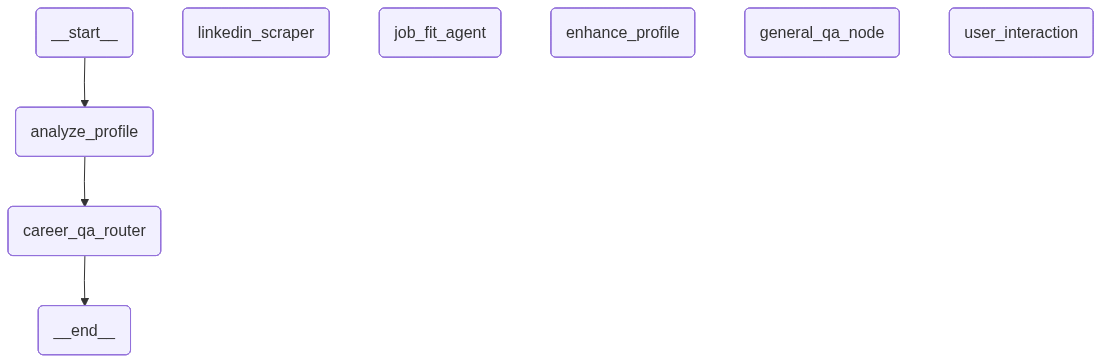

In [2]:
from IPython.display import Image, display
    # Assuming 'graph' is your compiled LangGraph object
display(Image(qa_graph.get_graph().draw_mermaid_png(max_retries=5)))